(B) XGBoost wildfire classifier (model-specific section)
Baseline XGBoost.
We employ XGBClassifier(tree_method="hist") obtained through 50-trial random search, which explores depth, child weight, sampling rates, L1/L2 regularisation and learning rate. and is evaluated by global PR-AUC.
•	n_estimators = 2000 (upper bound with early stopping),
•	max_depth=5, min_child_weight=6,
•	subsample≈0.93, colsample_bytree≈0.81,
•	reg_lambda=1.0, reg_alpha=100.0,
•	learning_rate=0.07, best iteration ≈ 664 trees.
•	objective "binary:logistic", metrics logloss and aucpr,
•	early_stopping_rounds = 100, scale_pos_weight ≈ 3.94.
On validation: ROC-AUC ≈ 0.732, PR-AUC ≈ 0.448 (train ROC-AUC ≈ 0.868, PR-AUC ≈ 0.630). Per-year PR-AUC increases from ≈0.21 (2014) to ≈0.62 (2021), tracking the rising ignition prevalence in this period. We also attmpted to train a less regularized model (with max_depth=8, min_child_weight=2), though the performance on training set was better, the performance on validation wasn’t necessary better, it also generalized slightly wore on the test dataset. Therfore, we interpreted it as signs of overfititng and deccided to use the more regularized model above.
Final training.
A final XGBoost model with n_estimators = 665 and the hyperparameters described above is trained on the combined 2014–2021 training and validation data, using a freshly fitted preprocessing pipeline and a recomputed scale_pos_weight (≈ 3.94). This model is then kept fixed and applied to the 2022–2025 test set.
4. Results
4.1 Feature importance
Gain-based feature importance and SHAP values indicate that the most influential predictors are meteorological and fuel-danger variables: burning index, ERC, 1000-h fuel moisture, time since last precipitation, maximum precipitation, humidity, temperature, and ERC/FM1000 ratios. Spatial and seasonal features (latitude, longitude, and day-of-year sine/cosine terms) also show substantial importance. Land-cover and human-presence indicators contribute less in comparison. Taken together, these patterns are consistent with a model that primarily uses fire-danger and spatio-seasonal structure, with comparatively weaker direct reliance on variables representing anthropogenic ignition pressure.
4.2 Out-of-time performance (2022–2025) / Evaluation on test dataset
Default threshold 0.5.
•	ROC-AUC ≈ 0.654, PR-AUC ≈ 0.713,
•	Precision ≈ 0.70, Recall ≈ 0.47, F1 ≈ 0.56, Accuracy ≈ 0.58,
•	Confusion matrix: TN = 5912, FP = 2240, FN = 6017, TP = 5285.
Compared with validation, ROC-AUC is lower, indicating reduced ranking performance under the distribution shift described in the data section. The higher PR-AUC on the test period is consistent with the substantially larger positive base rate there.
Across 2022–2025, this model outperforms both the temperature baseline and a random 50/50 classifier in F1 (0.56 vs. 0.43 and 0.53) and accuracy (0.58 vs. 0.49 and 0.49), and it also achieves higher precision (0.70 vs. 0.62 and 0.58). The random classifier attains slightly higher recall than our model (0.49 vs. 0.47), whereas the baseline underperforms on all reported metrics.
 4.3 Calibration
On the 2022–2025 test set, the calibration curve (10 quantile bins) yields a Brier score of 0.251. The empirical curve lies above the diagonal for most of the range: scores between 0.1 and 0.6 correspond to observed ignition frequencies of roughly 0.5–0.7, and scores near 0.8 are close to perfectly calibrated. Thus, the model systematically underestimates ignition risk, and its probabilities are better interpreted as relative risk scores than as well-calibrated absolute probabilities (they perform only slightly better than a constant predictor at the test-set prevalence ≈0.58).
At the default threshold 0.5, the test performance is precision 0.702, recall 0.468, F1 0.561, and accuracy 0.576 (TN = 5912, FP = 2240, FN = 6017, TP = 5285). A threshold sweep on the validation set targeting high recall selects a global threshold of 0.310 (validation precision 0.260, recall 0.906). Applied to the test set, this threshold yields precision 0.645, recall 0.794, F1 0.712, and accuracy 0.627 (TN = 3215, FP = 4937, FN = 2330, TP = 8972). ROC-AUC (0.654) and PR-AUC (0.713) remain unchanged, as expected for threshold-invariant metrics.
Guided by error analysis, we then define three regimes (urban, high-elevation shrub/forest with high ERC/FM1000 and ERC/FM1000·slope, and a base regime) and apply regime-conditional thresholds. Starting from the global high-recall threshold (0.310), we tune urban and high-elevation offsets on the validation set using a score that rewards F1 while penalising false negatives in urban and high-elevation regimes. The selected offsets (urban −0.06, high-elevation −0.04) yield, on the test set, precision 0.642, recall 0.844, F1 0.729, and accuracy 0.636 (TN = 2831, FP = 5321, FN = 1765, TP = 9537).
To approximate operational impacts, we evaluate a cost model with cost(FN) = c_{\mathrm{FN}} and cost(FP) = c_{\mathrm{FP}} for c_{\mathrm{FN}} \in \{5, 10, 20\} and c_{\mathrm{FP}} \in \{0.5, 1.0, 1.8465, 3.0\}, constrained to c_{\mathrm{FN}} > c_{\mathrm{FP}}. For all such cost pairs, the regime-conditional rule attains the lowest total cost among the three decision rules (threshold 0.5, global high-recall threshold 0.310, regime thresholds); for example, with c_{\mathrm{FN}} = 10 and c_{\mathrm{FP}} = 1.8465(average cost if we define urban=1, base=2, high.elev.=3), total cost decreases from 64 306 (0.5) to 32 416 (0.310) and further to 27 475 (regime thresholds). This indicates that high-recall and regime-aware thresholding can substantially increase recall and reduce a broad class of cost functionals without retraining the model.


## Imports and Helpers

In [ ]:
from pathlib import Path
import pandas as pd
from xgboost import XGBClassifier
from IPython.display import display
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import log_loss, roc_auc_score, average_precision_score
import numpy as np
import time
from sklearn.metrics import (
    precision_score, recall_score, f1_score, accuracy_score,
    roc_auc_score, average_precision_score,
    confusion_matrix, roc_curve, precision_recall_curve,
)
from sklearn.base import clone
from xgboost import plot_importance
import shap
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import brier_score_loss
from sklearn.calibration import calibration_curve

In [ ]:
# Absolute CSV paths provided by the user
TRAIN_PATH = Path("/Users/anatolelobenko/Downloads/terrain_outputs/dataset_with_terrain_new_train_2014_2021.csv")
TEST_PATH = Path("/Users/anatolelobenko/Downloads/terrain_outputs/dataset_with_terrain_new_test_2022_2025.csv")


TARGET_COLUMN = "Wildfire_bin"
RANDOM_STATE = 420

In [ ]:
from sklearn.metrics import classification_report, roc_auc_score

def evaluate_classifier(y_true, y_pred, y_proba, dataset_name: str = "dataset"):
    """
    Print a standard classification report and ROC-AUC.

    Parameters
    ----------
    y_true : array-like
        Ground-truth binary labels.
    y_pred : array-like
        Hard class predictions (0/1).
    y_proba : array-like
        Predicted probabilities for the positive class (1).
    dataset_name : str
        Label used in printed output to identify the dataset.
    """
    print(f"\n=== Evaluation on {dataset_name} ===")
    print(classification_report(y_true, y_pred, digits=4))
    if y_proba is not None:
        try:
            auc = roc_auc_score(y_true, y_proba)
            print(f"ROC-AUC: {auc:.4f}")
        except ValueError as e:
            print(f"Could not compute ROC-AUC for {dataset_name}: {e}")

In [ ]:
def compare_to_temp_baseline(
    y_true,
    y_proba,
    temp_values,
    threshold_model: float = 0.5,
    temp_threshold: float = 300.0,
    dataset_name: str = "dataset",
):
    """Compare model performance to
    (i) a simple temperature-rule baseline, and
    (ii) a random 50/50 baseline (coin flip with p=0.5).

    Parameters
    ----------
    y_true : array-like of shape (n_samples,)
        True binary labels (0/1).
    y_proba : array-like of shape (n_samples,)
        Predicted probabilities for the positive class (fire = 1) from the model.
    temp_values : array-like of shape (n_samples,)
        Values of the temperature feature (e.g. `tmmx_mean_rt_50_59`).
    threshold_model : float, default=0.5
        Probability threshold used to convert y_proba into model class predictions.
    temp_threshold : float, default=300.0
        Threshold applied to `temp_values` for the temperature baseline:
        predict fire if temp_values > temp_threshold.
    dataset_name : str, default="dataset"
        Name of the dataset (used only for printing).

    Prints
    ------
    A small table (pandas DataFrame) with F1, precision, recall, and accuracy
    for:
      - the XGB model at the chosen threshold,
      - the naive baseline which always predicts 0 (no fire),
      - the temperature-rule baseline, and
      - the random 50/50 baseline.
    """
    y_true = np.asarray(y_true)
    y_proba = np.asarray(y_proba)
    temp_values = np.asarray(temp_values)

    # Model predictions at given threshold
    y_pred_model = (y_proba >= threshold_model).astype(int)

    # Baseline (i): temperature rule
    y_pred_temp = (temp_values > temp_threshold).astype(int)

    # Baseline (ii): random 50/50 prediction (fair coin flip)
    rng = np.random.default_rng(RANDOM_STATE)  # fixed seed for reproducibility
    y_pred_5050 = rng.integers(0, 2, size=y_true.shape[0])

    def _metric_dict(y_true_local, y_pred_local):
        return {
            "f1": f1_score(y_true_local, y_pred_local),
            "precision": precision_score(y_true_local, y_pred_local, zero_division=0),
            "recall": recall_score(y_true_local, y_pred_local),
            "accuracy": accuracy_score(y_true_local, y_pred_local),
        }

    metrics_model = _metric_dict(y_true, y_pred_model)
    metrics_temp = _metric_dict(y_true, y_pred_temp)
    metrics_5050 = _metric_dict(y_true, y_pred_5050)

    df_cmp = pd.DataFrame(
        {
            "model": metrics_model,
            "temp_baseline": metrics_temp,
            "random_50_50": metrics_5050,
        }
    )

    print(
        f"\n=== Model vs naive, temperature, and random 50/50 baseline on {dataset_name} "
        f"(model_thr={threshold_model:.3f}, temp_thr={temp_threshold:.1f}) ==="
    )
    display(df_cmp)

In [ ]:
def pr_auc_by_year(y_true, y_proba, years):
    """
    Compute PR-AUC per year and summarise mean/std.

    Parameters
    ----------
    y_true : array-like
        Binary labels for the validation set.
    y_proba : array-like
        Predicted probabilities for the validation set.
    years : array-like
        Year for each sample in the validation set (e.g. val_df['year'].values)

    Returns
    -------
    metrics : dict
        {
          'per_year': {2019: pr_2019, 2020: pr_2020, ...},
          'mean': mean_pr,
          'std': std_pr,
          'min': min_pr,
        }
    """
    y_true = np.asarray(y_true)
    y_proba = np.asarray(y_proba)
    years = np.asarray(years)

    per_year = {}
    for yr in np.unique(years):
        mask = years == yr
        if mask.sum() == 0:
            continue
        pr = average_precision_score(y_true[mask], y_proba[mask])
        per_year[int(yr)] = pr

    vals = np.array(list(per_year.values()))
    return {
        "per_year": per_year,
        "mean": float(vals.mean()),
        "std": float(vals.std(ddof=0)),
        "min": float(vals.min()),
    }

In [ ]:
def choose_threshold_for_high_recall(
    y_true,
    y_proba,
    recall_target=0.90,
    grid=None,
):
    """
    Choose a probability threshold that achieves at least `recall_target`
    on the positive class, and among those thresholds maximise precision
    (equivalently, minimise false positives).

    If no threshold reaches `recall_target`, the function returns the
    threshold that attains the highest recall.
    """
    y_true = np.asarray(y_true)
    y_proba = np.asarray(y_proba)

    if grid is None:
        # Reasonable 1%-step grid; you can refine if needed
        grid = np.linspace(0.01, 0.99, 99)

    best_thr = None
    best_prec = -1.0
    best_rec = -1.0
    best_counts = None

    # First pass: check whether any threshold achieves recall_target
    max_recall_overall = 0.0

    for thr in grid:
        y_pred = (y_proba >= thr).astype(int)
        rec = recall_score(y_true, y_pred)
        max_recall_overall = max(max_recall_overall, rec)

        if rec >= recall_target:
            prec = precision_score(y_true, y_pred, zero_division=0)
            fp = ((y_true == 0) & (y_pred == 1)).sum()
            fn = ((y_true == 1) & (y_pred == 0)).sum()

            # maximise precision under recall constraint
            if prec > best_prec:
                best_prec = prec
                best_rec = rec
                best_thr = thr
                best_counts = {"fp": int(fp), "fn": int(fn)}

    # If we never reached recall_target, fall back to "best possible recall"
    if best_thr is None:
        print(
            f"Warning: recall_target={recall_target:.2f} not reachable. "
            f"Max recall on grid is {max_recall_overall:.3f}. "
            "Falling back to threshold with maximum recall."
        )

        best_thr = None
        best_rec = -1.0

        for thr in grid:
            y_pred = (y_proba >= thr).astype(int)
            rec = recall_score(y_true, y_pred)
            if rec > best_rec:
                best_rec = rec
                prec = precision_score(y_true, y_pred, zero_division=0)
                fp = ((y_true == 0) & (y_pred == 1)).sum()
                fn = ((y_true == 1) & (y_pred == 0)).sum()
                best_thr = thr
                best_prec = prec
                best_counts = {"fp": int(fp), "fn": int(fn)}

    return best_thr, {
        "precision": float(best_prec),
        "recall": float(best_rec),
        "counts": best_counts,
    }

In [ ]:
def eval_multiple_splits(splits, threshold=0.5, title_prefix="XGB – final model"):
    """
    Evaluate a classifier on multiple dataset splits using a fixed threshold.

    Parameters
    ----------
    splits : list of (str, array-like, array-like)
        List of (name, y_true, y_proba) tuples for each split.
    threshold : float, default=0.5
        Probability threshold used to convert y_proba into class predictions.
    title_prefix : str
        Prefix for the titles of the ROC and PR curve plots.

    Returns
    -------
    results : list of dict
        Per-split metrics (precision, recall, f1, accuracy, ROC-AUC, PR-AUC)
        and confusion matrices.
    """

    # --- scalar metrics & confusion matrices per split ---
    results = []
    for name, y_true, y_proba in splits:
        y_pred = (np.asarray(y_proba) >= threshold).astype(int)

        prec = precision_score(y_true, y_pred, zero_division=0)
        rec  = recall_score(y_true, y_pred)
        f1   = f1_score(y_true, y_pred)
        acc  = accuracy_score(y_true, y_pred)
        roc  = roc_auc_score(y_true, y_proba)
        pr   = average_precision_score(y_true, y_proba)
        cm   = confusion_matrix(y_true, y_pred)

        print(f"\n=== {name} @ thr={threshold:.3f} ===")
        print(f"precision : {prec:.4f}")
        print(f"recall    : {rec:.4f}")
        print(f"f1        : {f1:.4f}")
        print(f"accuracy  : {acc:.4f}")
        print(f"roc_auc   : {roc:.4f}")
        print(f"pr_auc    : {pr:.4f}")
        print("Confusion matrix:\n", cm)

        results.append({
            "name": name,
            "precision": prec,
            "recall": rec,
            "f1": f1,
            "accuracy": acc,
            "roc_auc": roc,
            "pr_auc": pr,
            "confusion_matrix": cm,
        })

    # --- merged ROC curves ---
    plt.figure(figsize=(7, 7))
    for name, y_true, y_proba in splits:
        fpr, tpr, _ = roc_curve(y_true, y_proba)
        roc_auc = roc_auc_score(y_true, y_proba)
        plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.3f})")
    plt.plot([0, 1], [0, 1], linestyle="--", linewidth=1, label="Random")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC curves – {title_prefix}")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()

    # --- merged PR curves ---
    plt.figure(figsize=(7, 7))
    for name, y_true, y_proba in splits:
        precision_curve, recall_curve, _ = precision_recall_curve(y_true, y_proba)
        ap = average_precision_score(y_true, y_proba)
        plt.plot(recall_curve, precision_curve, label=f"{name} (AP={ap:.3f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision–Recall curves – {title_prefix}")
    plt.legend(loc="lower left")
    plt.grid(True)
    plt.tight_layout()

    return results

In [ ]:
def build_error_df(X, y_true, y_proba, split_name, threshold=0.48):
    """
    Build a DataFrame that annotates each sample with:
      - true label (y_true)
      - predicted probability (y_proba)
      - hard prediction at a given threshold (y_pred)
      - error type (TP / FP / FN / TN)
      - split name
    """
    y_true = np.asarray(y_true)
    y_proba = np.asarray(y_proba)
    y_pred = (y_proba >= threshold).astype(int)

    df = X.copy().reset_index(drop=True)
    df["y_true"] = y_true
    df["y_pred"] = y_pred
    df["y_proba"] = y_proba
    df["split"] = split_name

    # Encode error type
    error_type = np.empty_like(y_true, dtype=object)
    error_type[(y_true == 1) & (y_pred == 1)] = "TP"
    error_type[(y_true == 0) & (y_pred == 0)] = "TN"
    error_type[(y_true == 0) & (y_pred == 1)] = "FP"
    error_type[(y_true == 1) & (y_pred == 0)] = "FN"
    df["error_type"] = error_type

    return df

In [ ]:
def plot_geo_errors(df_err, sample_frac=0.2, random_state=42):
    """
    Scatter plot of latitude/longitude with points coloured by error_type.
    Useful to see spatial clustering of FP / FN.

    sample_frac: subsample for speed/clarity; set to 1.0 to use all points.
    """
    cols_needed = {"latitude", "longitude", "error_type"}
    missing = cols_needed - set(df_err.columns)
    if missing:
        raise KeyError(f"Missing columns for geo plot: {missing}")

    if 0 < sample_frac < 1.0:
        df_plot = df_err.sample(frac=sample_frac, random_state=random_state)
    else:
        df_plot = df_err

    plt.figure(figsize=(7, 6))

    for et, marker in zip(["TP", "FN", "FP", "TN"], ["o", "x", "^", "."]):
        sub = df_plot[df_plot["error_type"] == et]
        if sub.empty:
            continue
        plt.scatter(
            sub["longitude"],
            sub["latitude"],
            s=10,
            alpha=0.5,
            label=f"{et} (n={len(sub)})",
            marker=marker,
        )

    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title("Spatial distribution of error types")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
def get_extreme_errors(df_err, error_type="FN", k=20):
    """
    Return the top-k 'worst' errors of a given type based on model confidence.

    - For FN: sort by ascending y_proba (model strongly believes 'no fire').
    - For FP: sort by descending y_proba (model strongly believes 'fire').
    - TP/TN can also be inspected if desired.
    """
    if error_type not in {"TP", "FP", "FN", "TN"}:
        raise ValueError("error_type must be one of {'TP', 'FP', 'FN', 'TN'}")

    df_sub = df_err[df_err["error_type"] == error_type].copy()
    if df_sub.empty:
        print(f"No samples of type {error_type}.")
        return df_sub

    if error_type in {"FN"}:
        df_sub = df_sub.sort_values("y_proba", ascending=True)
    elif error_type in {"FP"}:
        df_sub = df_sub.sort_values("y_proba", ascending=False)
    else:
        # For TP/TN, still sort by |y_proba - y_true| to see least calibrated
        df_sub["conf_gap"] = (df_sub["y_proba"] - df_sub["y_true"]).abs()
        df_sub = df_sub.sort_values("conf_gap", ascending=False)

    return df_sub.head(k)

In [ ]:
def plot_confusion_matrix_from_proba(
    y_true,
    y_proba,
    threshold=0.5,
    labels=(0, 1),
    label_names=("no fire", "fire"),
    title="Confusion matrix"
):
    """
    Compute and plot a confusion matrix for a given dataset, using
    predicted probabilities and a fixed decision threshold.

    Parameters
    ----------
    y_true : array-like
        True labels (0/1).
    y_proba : array-like
        Predicted probabilities for the positive class (fire = 1).
    threshold : float
        Decision threshold applied to y_proba.
    labels : tuple
        Order of class labels in the confusion matrix.
    label_names : tuple
        Human-readable names for the classes (same order as labels).
    title : str
        Plot title.
    """
    y_true = np.asarray(y_true)
    y_proba = np.asarray(y_proba)
    y_pred = (y_proba >= threshold).astype(int)

    cm = confusion_matrix(y_true, y_pred, labels=labels)
    tn, fp, fn, tp = cm.ravel()

    print(f"{title} @ thr={threshold:.3f}")
    print("Confusion matrix (rows = true, cols = predicted):")
    print(cm)
    print(f"\nTN={tn}, FP={fp}, FN={fn}, TP={tp}")

    # Normalised version (per true class)
    cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)
    print("\nRow-normalised confusion matrix:")
    print(cm_norm)

    # --- Heatmap plot ---
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))

    im0 = ax[0].imshow(cm, interpolation="nearest")
    ax[0].set_title("Counts")
    ax[0].set_xticks([0, 1])
    ax[0].set_yticks([0, 1])
    ax[0].set_xticklabels(label_names)
    ax[0].set_yticklabels(label_names)
    ax[0].set_xlabel("Predicted label")
    ax[0].set_ylabel("True label")
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax[0].text(j, i, cm[i, j], ha="center", va="center")

    im1 = ax[1].imshow(cm_norm, interpolation="nearest", vmin=0, vmax=1)
    ax[1].set_title("Row-normalised")
    ax[1].set_xticks([0, 1])
    ax[1].set_yticks([0, 1])
    ax[1].set_xticklabels(label_names)
    ax[1].set_yticklabels(label_names)
    ax[1].set_xlabel("Predicted label")
    for i in range(cm_norm.shape[0]):
        for j in range(cm_norm.shape[1]):
            ax[1].text(j, i, f"{cm_norm[i, j]:.2f}", ha="center", va="center")

    fig.colorbar(im0, ax=ax[0], fraction=0.046, pad=0.04)
    fig.colorbar(im1, ax=ax[1], fraction=0.046, pad=0.04)

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

    return cm, cm_norm

In [ ]:
def plot_calibration(y_true, y_proba, dataset_name="dataset", n_bins=10):
    prob_true, prob_pred = calibration_curve(y_true, y_proba, n_bins=n_bins, strategy="quantile")
    brier = brier_score_loss(y_true, y_proba)

    plt.figure(figsize=(6, 6))
    plt.plot(prob_pred, prob_true, marker="o", linewidth=1, label="Empirical")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("Predicted probability")
    plt.ylabel("Observed frequency")
    plt.title(f"Calibration curve – {dataset_name}\nBrier score = {brier:.3f}")
    plt.grid(True)
    plt.legend()
    plt.show()
    return brier

In [ ]:
def make_regime_masks(
    df,
    human_presence_thr,
    elevation_thr,
    erc_thr,
    erc_slope_thr,
):
    # Urban / high human presence regime
    urban_mask = (
        (df["nlcd_developed"] == 1) |
        (df["nlcd_human_presence"] > human_presence_thr)
    )

    # High-elevation shrub or forest
    shrub_forest_mask = (
        (df["nlcd_shrub"] == 1) |
        (df["nlcd_forest"] == 1)
    )

    high_elev_mask = df["elevation_m"] > elevation_thr
    high_energy_mask = (
        (df["erc_over_fm1000"] > erc_thr) &
        (df["erc_over_fm1000_slope"] > erc_slope_thr)
    )

    high_elev_fuel_mask = shrub_forest_mask & high_elev_mask & high_energy_mask

    base_mask = ~(urban_mask | high_elev_fuel_mask)

    return {
        "urban": urban_mask.values,
        "high_elev_fuel": high_elev_fuel_mask.values,
        "base": base_mask.values,
    }

In [ ]:
def eval_regime_thresholds(
    human_presence_thr,
    elevation_thr,
    erc_thr,
    erc_slope_thr,
    thr_base,
    thr_urban_delta=0.0,
    thr_high_elev_delta=0.0,
):
    # 1) build regimes on VAL
    regimes_val = make_regime_masks(
        val_df,
        human_presence_thr=human_presence_thr,
        elevation_thr=elevation_thr,
        erc_thr=erc_thr,
        erc_slope_thr=erc_slope_thr,
    )

    # 2) apply regime-conditional thresholds
    y_pred_val, thr_used_val = predict_with_regime_thresholds(
        y_proba=y_val_proba_s2,
        regimes=regimes_val,
        thr_base=thr_base,
        thr_urban_delta=thr_urban_delta,
        thr_high_elev_delta=thr_high_elev_delta,
    )

    # 3) global metrics
    prec = precision_score(y_val, y_pred_val, zero_division=0)
    rec  = recall_score(y_val, y_pred_val)
    f1   = f1_score(y_val, y_pred_val)

    # 4) regime-specific FN rates (example: you care a lot about urban FNs)
    urban_mask = regimes_val["urban"]
    y_true_u = y_val.values[urban_mask]
    y_pred_u = y_pred_val[urban_mask]

    fn_u = ((y_true_u == 1) & (y_pred_u == 0)).sum()
    tp_u = ((y_true_u == 1) & (y_pred_u == 1)).sum()
    urban_fn_rate = fn_u / (fn_u + tp_u + 1e-9)

    high_mask = regimes_val["high_elev_fuel"]
    y_true_h = y_val.values[high_mask]
    y_pred_h = y_pred_val[high_mask]
    fn_h = ((y_true_h == 1) & (y_pred_h == 0)).sum()
    tp_h = ((y_true_h == 1) & (y_pred_h == 1)).sum()
    high_fn_rate = fn_h / (fn_h + tp_h + 1e-9)

    return {
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "urban_fn_rate": urban_fn_rate,
        "high_fn_rate": high_fn_rate,
    }

In [ ]:
def plot_confusion_matrix_from_preds(
    y_true,
    y_pred,
    labels=(0, 1),
    label_names=("no fire", "fire"),
    title="Confusion matrix",
):
    """
    Plot and print a confusion matrix given true labels and hard predictions.

    Parameters
    ----------
    y_true : array-like
        True binary labels.
    y_pred : array-like
        Hard predictions (0/1).
    labels : tuple, default=(0, 1)
        Order of class labels in the confusion matrix.
    label_names : tuple, default=("no fire", "fire")
        Human-readable names for the classes (same order as `labels`).
    title : str, default="Confusion matrix"
        Plot title.

    Returns
    -------
    cm : ndarray of shape (2, 2)
        Confusion matrix with counts.
    cm_norm : ndarray of shape (2, 2)
        Row-normalised confusion matrix.
    """
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)

    cm = confusion_matrix(y_true, y_pred, labels=labels)
    tn, fp, fn, tp = cm.ravel()

    print(title)
    print("Confusion matrix (rows = true, cols = predicted):")
    print(cm)
    print(f"\nTN={tn}, FP={fp}, FN={fn}, TP={tp}")

    # Normalised version (per true class)
    cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)
    print("\nRow-normalised confusion matrix:")
    print(cm_norm)

    # --- Heatmap plot ---
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))

    # Counts
    im0 = ax[0].imshow(cm, interpolation="nearest")
    ax[0].set_title("Counts")
    ax[0].set_xticks([0, 1])
    ax[0].set_yticks([0, 1])
    ax[0].set_xticklabels(label_names)
    ax[0].set_yticklabels(label_names)
    ax[0].set_xlabel("Predicted label")
    ax[0].set_ylabel("True label")
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax[0].text(j, i, cm[i, j], ha="center", va="center")

    # Row-normalised
    im1 = ax[1].imshow(cm_norm, interpolation="nearest", vmin=0, vmax=1)
    ax[1].set_title("Row-normalised")
    ax[1].set_xticks([0, 1])
    ax[1].set_yticks([0, 1])
    ax[1].set_xticklabels(label_names)
    ax[1].set_yticklabels(label_names)
    ax[1].set_xlabel("Predicted label")
    for i in range(cm_norm.shape[0]):
        for j in range(cm_norm.shape[1]):
            ax[1].text(j, i, f"{cm_norm[i, j]:.2f}", ha="center", va="center")

    fig.colorbar(im0, ax=ax[0], fraction=0.046, pad=0.04)
    fig.colorbar(im1, ax=ax[1], fraction=0.046, pad=0.04)

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

    return cm, cm_norm

## Load, Preprocess and Transform

In [ ]:
def load_dataset(path: Path) -> pd.DataFrame:
    """
    Load a pre-processed wildfire dataset from CSV.

    Parameters
    ----------
    path : Path
        Absolute path to the CSV file.

    Returns
    -------
    pd.DataFrame
        DataFrame containing features and the `Wildfire_bin` target.

    Raises
    ------
    FileNotFoundError
        If the specified file does not exist.
    KeyError
        If the target column is missing from the file.
    """
    if not path.exists():
        raise FileNotFoundError(f"File not found: {path}")
    df = pd.read_csv(path)
    if TARGET_COLUMN not in df.columns:
        raise KeyError(
            f"TARGET_COLUMN='{TARGET_COLUMN}' not found in {path.name}. "
            f"Available columns: {list(df.columns)[:20]}..."
        )
    return df


train_df = load_dataset(TRAIN_PATH)
test_df = load_dataset(TEST_PATH)
## Random split of training data into train and validation (time-agnostic)
print("Before split:")
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)
from sklearn.model_selection import train_test_split

# 20% of the original training data will be used for validation
VAL_SIZE = 0.2  # adjust if needed

train_df, val_df = train_test_split(
    train_df,
    test_size=VAL_SIZE,
    stratify=train_df[TARGET_COLUMN],  # preserves class balance
    random_state=RANDOM_STATE,
)

print("After random split:")
print("Train shape:", train_df.shape)
print("Val   shape:", val_df.shape)
print("Test shape:", test_df.shape)

Before split:
Train shape: (106401, 57)
Test shape: (19454, 57)
After random split:
Train shape: (85120, 57)
Val   shape: (21281, 57)
Test shape: (19454, 57)


In [ ]:
# Columns we explicitly *exclude* from modelling
DROP_COLS = [
    # IDs / technical
    "runtime",
    "frame75_loc_id",
    "loc_id",
    "datetime",

    # redundant calendar fields
    "doy",
    "year",      # optional; try both with and without
    "month",
    "season",
    "date",
    # Next features were removed based on ablation studies (their contribution was not usefull) and some of them were highly correlated.
    # removing features:
    "weekday_sin","weekday_cos", "hdw_score", "weekday_weekend",

    #removing other feature step 2
    "vpd_times_wind", "wnd_slope", "dry_on_slope",

    #removing features 3:
    "dryness_score", "nlcd_wui_intensity",

    #removing features 4:
    "fm100_mean_rt_50_59", "t_range_mean_rt_50_59",


    #removing other feratures
    "pr_mean_rt_50_59", "pet_mean_rt_50_59", "pr_mean_rt_50_59", "pr_sum"
]

# Use all columns except target + dropped columns
feature_cols = [c for c in train_df.columns
                if c not in DROP_COLS and c != TARGET_COLUMN]

X_train = train_df[feature_cols]
y_train = train_df[TARGET_COLUMN]

X_val = val_df[feature_cols]
y_val = val_df[TARGET_COLUMN]

X_test = test_df[feature_cols]
y_test = test_df[TARGET_COLUMN]


# Basic sanity check: same feature columns in all datasets
for name, X in [("val", X_val), ("test", X_test)]:
    if list(X.columns) != feature_cols:
        raise ValueError(
            f"Feature columns for {name} set do not match train feature columns."
        )

numeric_cols = X_train.select_dtypes(
    include=["int16", "int32", "int64", "float16", "float32", "float64"]
).columns.tolist()

categorical_cols = [c for c in feature_cols if c not in numeric_cols]

print("Numeric columns:", len(numeric_cols))
print("Categorical columns:", len(categorical_cols))
print("Dropped columns:", DROP_COLS)
print("Total features used:", len(feature_cols))

Numeric columns: 34
Categorical columns: 0
Dropped columns: ['runtime', 'frame75_loc_id', 'loc_id', 'datetime', 'doy', 'year', 'month', 'season', 'date', 'weekday_sin', 'weekday_cos', 'hdw_score', 'weekday_weekend', 'vpd_times_wind', 'wnd_slope', 'dry_on_slope', 'dryness_score', 'nlcd_wui_intensity', 'fm100_mean_rt_50_59', 't_range_mean_rt_50_59', 'pr_mean_rt_50_59', 'pet_mean_rt_50_59', 'pr_mean_rt_50_59', 'pr_sum']
Total features used: 34


In [ ]:
#numeric_transformer = StandardScaler() #XGB doesnt need the scaling, ony craps XAI
categorical_transformer = OneHotEncoder(handle_unknown="ignore", sparse_output=True)

In [ ]:
# Identify binary vs. continuous numeric features.
# This allows us to treat them differently later if needed (e.g. for scaling
# or custom visualisation), while currently both are passed through unchanged.
# Identify binary columns
binary_cols = [
    c for c in numeric_cols
    if set(X_train[c].dropna().unique()) <= {0, 1}
]

real_cols = [c for c in numeric_cols if c not in binary_cols]

preprocessor = ColumnTransformer(
    transformers=[
        #("real", StandardScaler(), real_cols), #test to drop the StandScal
        ("real", "passthrough", real_cols),
        ("binary", "passthrough", binary_cols),
        ("cat", categorical_transformer, categorical_cols),
    ],
    remainder="drop",
)

In [ ]:
# 1) Preprocess explicitly
X_train_proc = preprocessor.fit_transform(X_train)
X_val_proc   = preprocessor.transform(X_val)

# 2) Compute scale_pos_weight from *training* labels
n_pos = (y_train == 1).sum()
n_neg = (y_train == 0).sum()
scale_pos_weight = n_neg / n_pos

print("Positives (2014–2021):", n_pos)
print("Negatives (2014–2021):", n_neg)
print("scale_pos_weight:", scale_pos_weight)

Positives (2014–2021): 17245
Negatives (2014–2021): 67875
scale_pos_weight: 3.9359234560742244


## Training initial model

warming up...

In [ ]:
xgb_model = XGBClassifier(
    n_estimators=2000,           # large upper bound
    learning_rate=0.01,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    tree_method="hist",
    eval_metric=["logloss", "aucpr"],
    early_stopping_rounds=100,
    n_jobs=-1,
    random_state=RANDOM_STATE,
    scale_pos_weight=scale_pos_weight,
)

print("Fitting XGBoost with early stopping...")
xgb_model.fit(
    X_train_proc,
    y_train,
    eval_set=[(X_val_proc, y_val)],
    verbose=False,
)

print("Best iteration:", xgb_model.best_iteration)
print("Best score:", xgb_model.best_score)

# 3) Evaluation
from sklearn.metrics import log_loss, roc_auc_score, average_precision_score

y_val_proba = xgb_model.predict_proba(X_val_proc)[:, 1]
print("Val logloss:", log_loss(y_val, y_val_proba))
print("Val ROC AUC:", roc_auc_score(y_val, y_val_proba))
print("Val PR AUC:", average_precision_score(y_val, y_val_proba))

Fitting XGBoost with early stopping...
Best iteration: 1999
Best score: 0.4277792608170551
Val logloss: 0.5980805847741346
Val ROC AUC: 0.721057723680921
Val PR AUC: 0.4280040108220762


In [ ]:
X_val_proc = preprocessor.transform(X_val)
y_val_pred = xgb_model.predict(X_val_proc)
y_val_proba = xgb_model.predict_proba(X_val_proc)[:, 1]
evaluate_classifier(y_val, y_val_pred, y_val_proba, dataset_name="validation")


=== Evaluation on validation ===
              precision    recall  f1-score   support

           0     0.8834    0.6416    0.7433     16970
           1     0.3209    0.6667    0.4333      4311

    accuracy                         0.6467     21281
   macro avg     0.6022    0.6541    0.5883     21281
weighted avg     0.7695    0.6467    0.6805     21281

ROC-AUC: 0.7211


## Random Search and Retrain

In [ ]:
def fit_and_eval_xgb(params, X_train_proc, y_train, X_val_proc, y_val, val_years):
    model = XGBClassifier(
        n_estimators=2000,
        learning_rate=params["learning_rate"],
        max_depth=params["max_depth"],
        min_child_weight=params["min_child_weight"],
        subsample=params["subsample"],
        colsample_bytree=params["colsample_bytree"],
        reg_lambda=params["reg_lambda"],
        objective="binary:logistic",
        tree_method="hist",
        eval_metric=["logloss", "aucpr"],
        early_stopping_rounds=50,
        n_jobs=-1,
        random_state=RANDOM_STATE,
        scale_pos_weight=scale_pos_weight,
    )

    model.fit(
        X_train_proc,
        y_train,
        eval_set=[(X_val_proc, y_val)],
        verbose=False,
    )

    y_val_proba = model.predict_proba(X_val_proc)[:, 1]
    val_pr_auc = average_precision_score(y_val, y_val_proba)
    val_roc_auc = roc_auc_score(y_val, y_val_proba)
    val_logloss = log_loss(y_val, y_val_proba)
    best_iter    = model.best_iteration

          # NEW: per-year PR-AUC and stability statistics
    pr_year_stats = pr_auc_by_year(y_val, y_val_proba, val_years)
    pr_mean = pr_year_stats["mean"]
    pr_std  = pr_year_stats["std"]
    pr_min  = pr_year_stats["min"]

    return model, val_pr_auc, val_roc_auc, val_logloss, best_iter, pr_year_stats

In [ ]:
def sample_params_stage1(rng):
    params = {
            # depth: prefer moderately deep trees
            "max_depth": int(rng.integers(3, 6)),  # 4,5,6

            # child weight: emphasise small/moderate values
            "min_child_weight": int(rng.choice([4,5,5,5,6,6,7,8,9,10,11,12,13])),

            # subsample/colsample: moderately high
            "subsample": float(0.5 + 0.5 * rng.beta(2.0, 1.0)),
            "colsample_bytree": float(0.5 + 0.5 * rng.beta(2.0, 1.0)),

            "reg_lambda": float(rng.choice([0.1,0.5, 1, 5, 10, 50, 100, 200])),
            "reg_alpha": float(rng.choice([0.1,0.5, 1, 5, 10, 50, 100, 100])),

            "learning_rate": float(rng.choice([0.01, 0.03,  0.05, 0.07, 0.1])),
    }
    return params
def random_search_xgb(n_trials=200, random_state=RANDOM_STATE):
    rng = np.random.default_rng(random_state)

    best_model = None
    best_params = None
    best_pr_auc = -np.inf
    best_pr_year_stats = None
    records = []

    start_all = time.time()
    val_years = val_df["year"].values
    for i in range(1, n_trials + 1):
        params = sample_params_stage1(rng)

        t0 = time.time()
        #model, val_pr, val_roc, val_logloss, best_iter = fit_and_eval_xgb(params)
        model, val_pr, val_roc, val_logloss, best_iter, pr_year_stats = fit_and_eval_xgb(
    params, X_train_proc, y_train, X_val_proc, y_val, val_years
    )
        dt = time.time() - t0

        records.append({
            "trial": i,
            **params,
            "val_pr_auc": val_pr,
            "val_roc_auc": val_roc,
            "val_logloss": val_logloss,
            "best_iteration": best_iter,
            "fit_time_sec": dt,
             **{f"val_pr_{yr}": pr for yr, pr in pr_year_stats["per_year"].items()},
        })

        if val_pr > best_pr_auc:
            best_pr_auc = val_pr
            best_model = model
            best_params = params
            best_pr_year_stats = pr_year_stats

        print(
            f"[{i:03d}/{n_trials}] "
            f"PR AUC={val_pr:.4f} (best={best_pr_auc:.4f}), "
            f"ROC AUC={val_roc:.4f}, logloss={val_logloss:.4f}, "
            f"best_iter={best_iter}, time={dt:.1f}s"
        )
        print("  params:", params)

    total_time = time.time() - start_all
    print(f"\nRandom search finished in {total_time/60:.1f} min")
    print("Best val PR AUC:", best_pr_auc)
    print("Best params:", best_params)

    results_df_stage2 = pd.DataFrame(records)
    return best_model, best_params, results_df_stage2, best_pr_year_stats


In [ ]:
best_model_rs, best_params_rs, results_df_rs, best_pr_year_stats = random_search_xgb(n_trials=75, random_state=RANDOM_STATE)

print("\n=== Best (random search) configuration ===")
print(best_params_rs)
print("Best val PR AUC:", results_df_rs["val_pr_auc"].max())

print("\nPer-year PR-AUC for best model:")
for yr, pr in sorted(best_pr_year_stats["per_year"].items()):
    print(f"  {yr}: {pr:.4f}")

print(f"\nMean PR-AUC across years: {best_pr_year_stats['mean']:.4f}")
print(f"Std  PR-AUC across years: {best_pr_year_stats['std']:.4f}")
print(f"Min  PR-AUC across years: {best_pr_year_stats['min']:.4f}")

[001/75] PR AUC=0.4401 (best=0.4401), ROC AUC=0.7284, logloss=0.5818, best_iter=932, time=2.9s
  params: {'max_depth': 4, 'min_child_weight': 11, 'subsample': 0.7932121290337633, 'colsample_bytree': 0.9543612955746079, 'reg_lambda': 0.5, 'reg_alpha': 0.1, 'learning_rate': 0.05}
[002/75] PR AUC=0.4192 (best=0.4401), ROC AUC=0.7155, logloss=0.6061, best_iter=1999, time=5.7s
  params: {'max_depth': 4, 'min_child_weight': 12, 'subsample': 0.8535924857006045, 'colsample_bytree': 0.7647519913293417, 'reg_lambda': 200.0, 'reg_alpha': 1.0, 'learning_rate': 0.01}
[003/75] PR AUC=0.4471 (best=0.4471), ROC AUC=0.7328, logloss=0.5725, best_iter=1190, time=3.7s
  params: {'max_depth': 5, 'min_child_weight': 11, 'subsample': 0.9066054970998063, 'colsample_bytree': 0.9941661270495271, 'reg_lambda': 5.0, 'reg_alpha': 0.5, 'learning_rate': 0.03}
[004/75] PR AUC=0.4360 (best=0.4471), ROC AUC=0.7259, logloss=0.5852, best_iter=1606, time=4.1s
  params: {'max_depth': 3, 'min_child_weight': 12, 'subsample':

In [ ]:
from sklearn.metrics import log_loss, roc_auc_score, average_precision_score

y_train_proba_s2 = best_model_rs.predict_proba(X_train_proc)[:, 1]
y_val_proba_s2   = best_model_rs.predict_proba(X_val_proc)[:, 1]

print("=== Best model – train vs val ===")
print("Train ROC AUC:", roc_auc_score(y_train, y_train_proba_s2))
print("Val   ROC AUC:", roc_auc_score(y_val,   y_val_proba_s2))
print("Train PR AUC: ", average_precision_score(y_train, y_train_proba_s2))
print("Val   PR AUC: ", average_precision_score(y_val,   y_val_proba_s2))
print("Train logloss:", log_loss(y_train, y_train_proba_s2))
print("Val   logloss:", log_loss(y_val,   y_val_proba_s2))

print("Best iteration:", best_model_rs.best_iteration)

=== Best model – train vs val ===
Train ROC AUC: 0.8676754617000042
Val   ROC AUC: 0.7317556245298681
Train PR AUC:  0.6302556080129141
Val   PR AUC:  0.44792877804942727
Train logloss: 0.5010905694391978
Val   logloss: 0.5647799546718363
Best iteration: 664


## Fitting our final model

In [ ]:
# Combine train and val
X_trainval = pd.concat([X_train, X_val], axis=0)
y_trainval = pd.concat([y_train, y_val], axis=0)

# Fresh preprocessor fitted on 2014–2021
preprocessor_final = clone(preprocessor)
X_trainval_proc = preprocessor_final.fit_transform(X_trainval)

# Recompute scale_pos_weight
n_pos_tv = (y_trainval == 1).sum()
n_neg_tv = (y_trainval == 0).sum()
scale_pos_weight_final = n_neg_tv / n_pos_tv

print("Positives (2014–2025):", n_pos_tv)
print("Negatives (2014–2025):", n_neg_tv)
print("scale_pos_weight_final:", scale_pos_weight_final)

Positives (2014–2025): 21556
Negatives (2014–2025): 84845
scale_pos_weight_final: 3.9360270922249025


In [ ]:
from xgboost import XGBClassifier

best_iter_s2 = best_model_rs.best_iteration
final_n_estimators = best_iter_s2 + 1   # trees are 0-indexed internally

final_model = XGBClassifier(
    n_estimators=final_n_estimators,
    learning_rate=best_params_rs["learning_rate"],
    max_depth=best_params_rs["max_depth"],
    min_child_weight=best_params_rs["min_child_weight"],
    subsample=best_params_rs["subsample"],
    colsample_bytree=best_params_rs["colsample_bytree"],
    reg_lambda=best_params_rs["reg_lambda"],
    reg_alpha=best_params_rs["reg_alpha"],
    objective="binary:logistic",
    tree_method="hist",
    eval_metric=["logloss", "aucpr"],
    n_jobs=-1,
    random_state=RANDOM_STATE,
    scale_pos_weight=scale_pos_weight_final,
)

print("Fitting FINAL model on 2014–2021...")
final_model.fit(X_trainval_proc, y_trainval)
print("Done.")

Fitting FINAL model on 2014–2021...
Done.


## Evaluation

In [ ]:
# Test
X_test1_proc = preprocessor_final.transform(X_test)
y_test1_proba = final_model.predict_proba(X_test1_proc)[:, 1]
y_test1_pred  = final_model.predict(X_test1_proc)
evaluate_classifier(y_test, y_test1_pred, y_test1_proba,
                    dataset_name="test (2022–2025)")



=== Evaluation on test (2022–2025) ===
              precision    recall  f1-score   support

           0     0.4956    0.7252    0.5888      8152
           1     0.7023    0.4676    0.5614     11302

    accuracy                         0.5756     19454
   macro avg     0.5990    0.5964    0.5751     19454
weighted avg     0.6157    0.5756    0.5729     19454

ROC-AUC: 0.6539



=== test (2022–2025) @ thr=0.500 ===
precision : 0.7023
recall    : 0.4676
f1        : 0.5614
accuracy  : 0.5756
roc_auc   : 0.6539
pr_auc    : 0.7127
Confusion matrix:
 [[5912 2240]
 [6017 5285]]


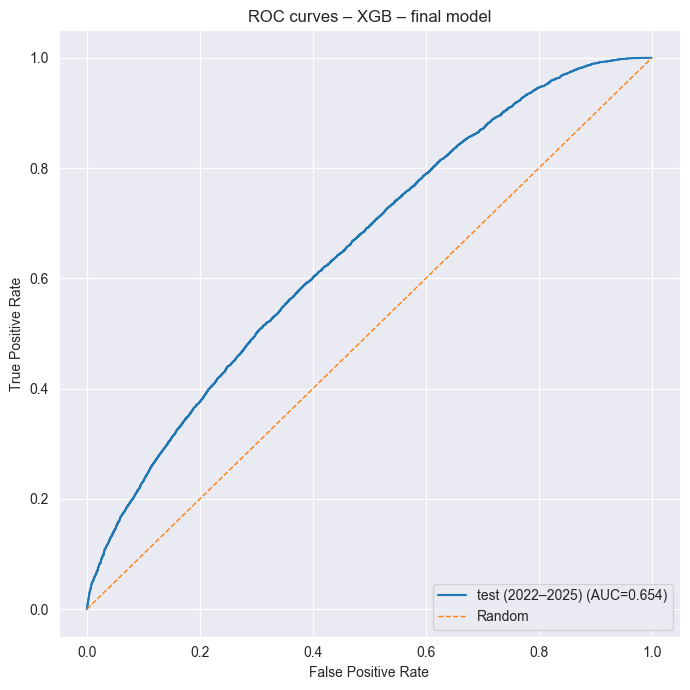

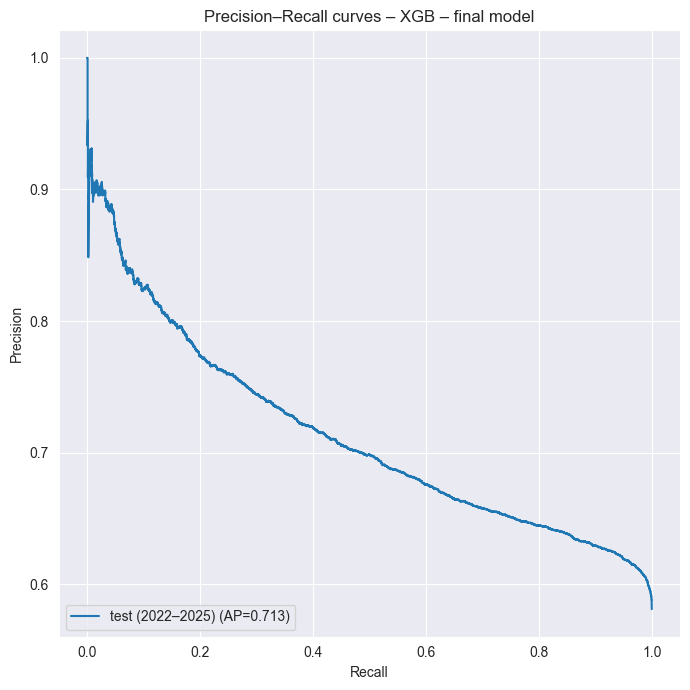

In [ ]:
splits = [
    ("test (2022–2025)", y_test, y_test1_proba),
]

results = eval_multiple_splits(splits, threshold=0.5)



In [ ]:
thr = 0.5

compare_to_temp_baseline(
    y_true=y_test,
    y_proba=y_test1_proba,
    temp_values=X_test["tmmx_mean_rt_50_59"],
    threshold_model=thr,
    temp_threshold=300.0,
    dataset_name="test (2022–2025)",
)


=== Model vs naive, temperature, and random 50/50 baseline on test (2022–2025) (model_thr=0.500, temp_thr=300.0) ===


model  temp_baseline  random_50_50
f1         0.561428       0.426074      0.530050
precision  0.702326       0.616209      0.576615
recall     0.467616       0.325606      0.490444
accuracy   0.575563       0.490388      0.494757

Confusion matrix – test (2022–2025) @ thr=0.500
Confusion matrix (rows = true, cols = predicted):
[[5912 2240]
 [6017 5285]]

TN=5912, FP=2240, FN=6017, TP=5285

Row-normalised confusion matrix:
[[0.7252208  0.2747792 ]
 [0.53238365 0.46761635]]


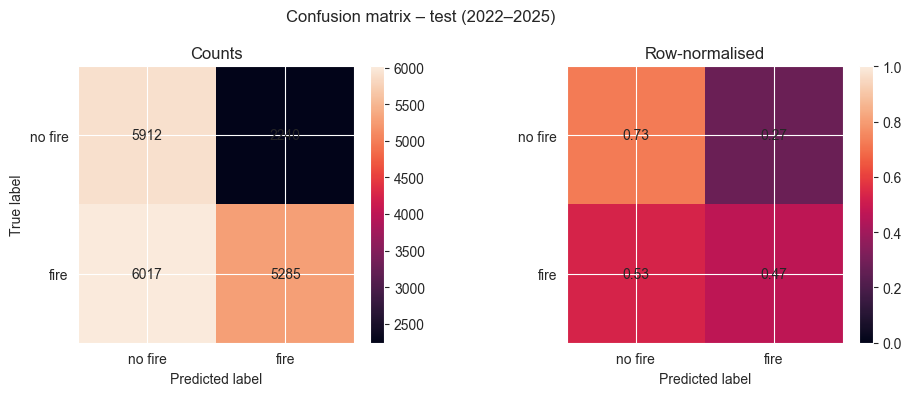

In [ ]:
cm_t1, cm_t1_norm = plot_confusion_matrix_from_proba(
    y_test,
    y_test1_proba,
    threshold=thr,
    title="Confusion matrix – test (2022–2025)"
)

## Interpretability

In [ ]:
def attach_feature_names_to_booster(preprocessor, xgb_model):
    """
    Attach human-readable feature names from a fitted sklearn preprocessor
    (e.g. ColumnTransformer) to a fitted XGBClassifier/XGBRegressor booster.
    """
    # Extract transformed feature names
    feature_names = preprocessor.get_feature_names_out()
    print("Number of transformed features:", len(feature_names))
    print("First 20 names:", feature_names[:20])

    # Extract booster and check consistency
    booster = xgb_model.get_booster()
    n_booster_features = booster.num_features()
    print("Booster num_features():", n_booster_features)

    if len(feature_names) != n_booster_features:
        raise ValueError(
            f"Mismatch between preprocessor features ({len(feature_names)}) "
            f"and booster features ({n_booster_features})."
        )

    # Attach names
    booster.feature_names = list(feature_names)
    return booster

In [ ]:
booster_final = attach_feature_names_to_booster(preprocessor_final, final_model)

Number of transformed features: 34
First 20 names: ['real__latitude' 'real__longitude' 'real__elevation_m' 'real__slope_deg'
 'real__since_prev_pr' 'real__pr_max' 'real__rmax_mean_rt_50_59'
 'real__rmin_mean_rt_50_59' 'real__sph_mean_rt_50_59'
 'real__srad_mean_rt_50_59' 'real__tmmn_mean_rt_50_59'
 'real__tmmx_mean_rt_50_59' 'real__vs_mean_rt_50_59'
 'real__bi_mean_rt_50_59' 'real__fm1000_mean_rt_50_59'
 'real__erc_mean_rt_50_59' 'real__etr_mean_rt_50_59'
 'real__vpd_mean_rt_50_59' 'real__doy_sin' 'real__doy_cos']
Booster num_features(): 34


<Figure size 800x1000 with 0 Axes>

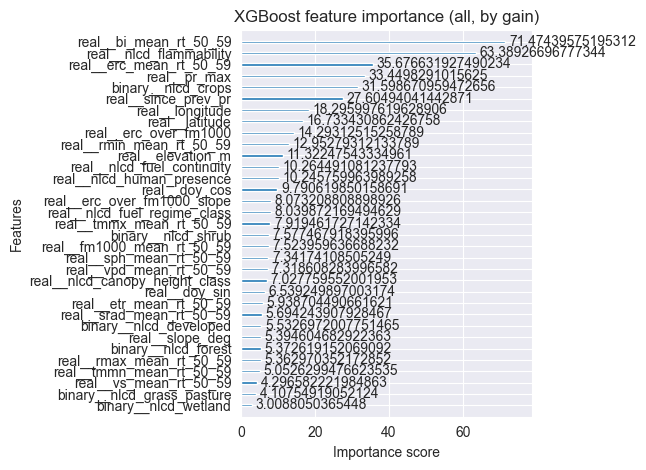

In [ ]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 10))

# importance_type can be 'gain', 'weight', or 'cover'
plot_importance(
    booster_final,
    importance_type="gain",   # average gain when a feature is used in splits
    max_num_features=47,
    show_values=True
)

plt.title("XGBoost feature importance (all, by gain)")
plt.tight_layout()
plt.show()

/Users/anatolelobenko/PyCharmMiscProject/.venv/lib/python3.13/site-packages/xgboost/plotting.py:267: FutureWarning: The `num_trees` parameter is deprecated, use `tree_idx` insetad. 
  warnings.warn(


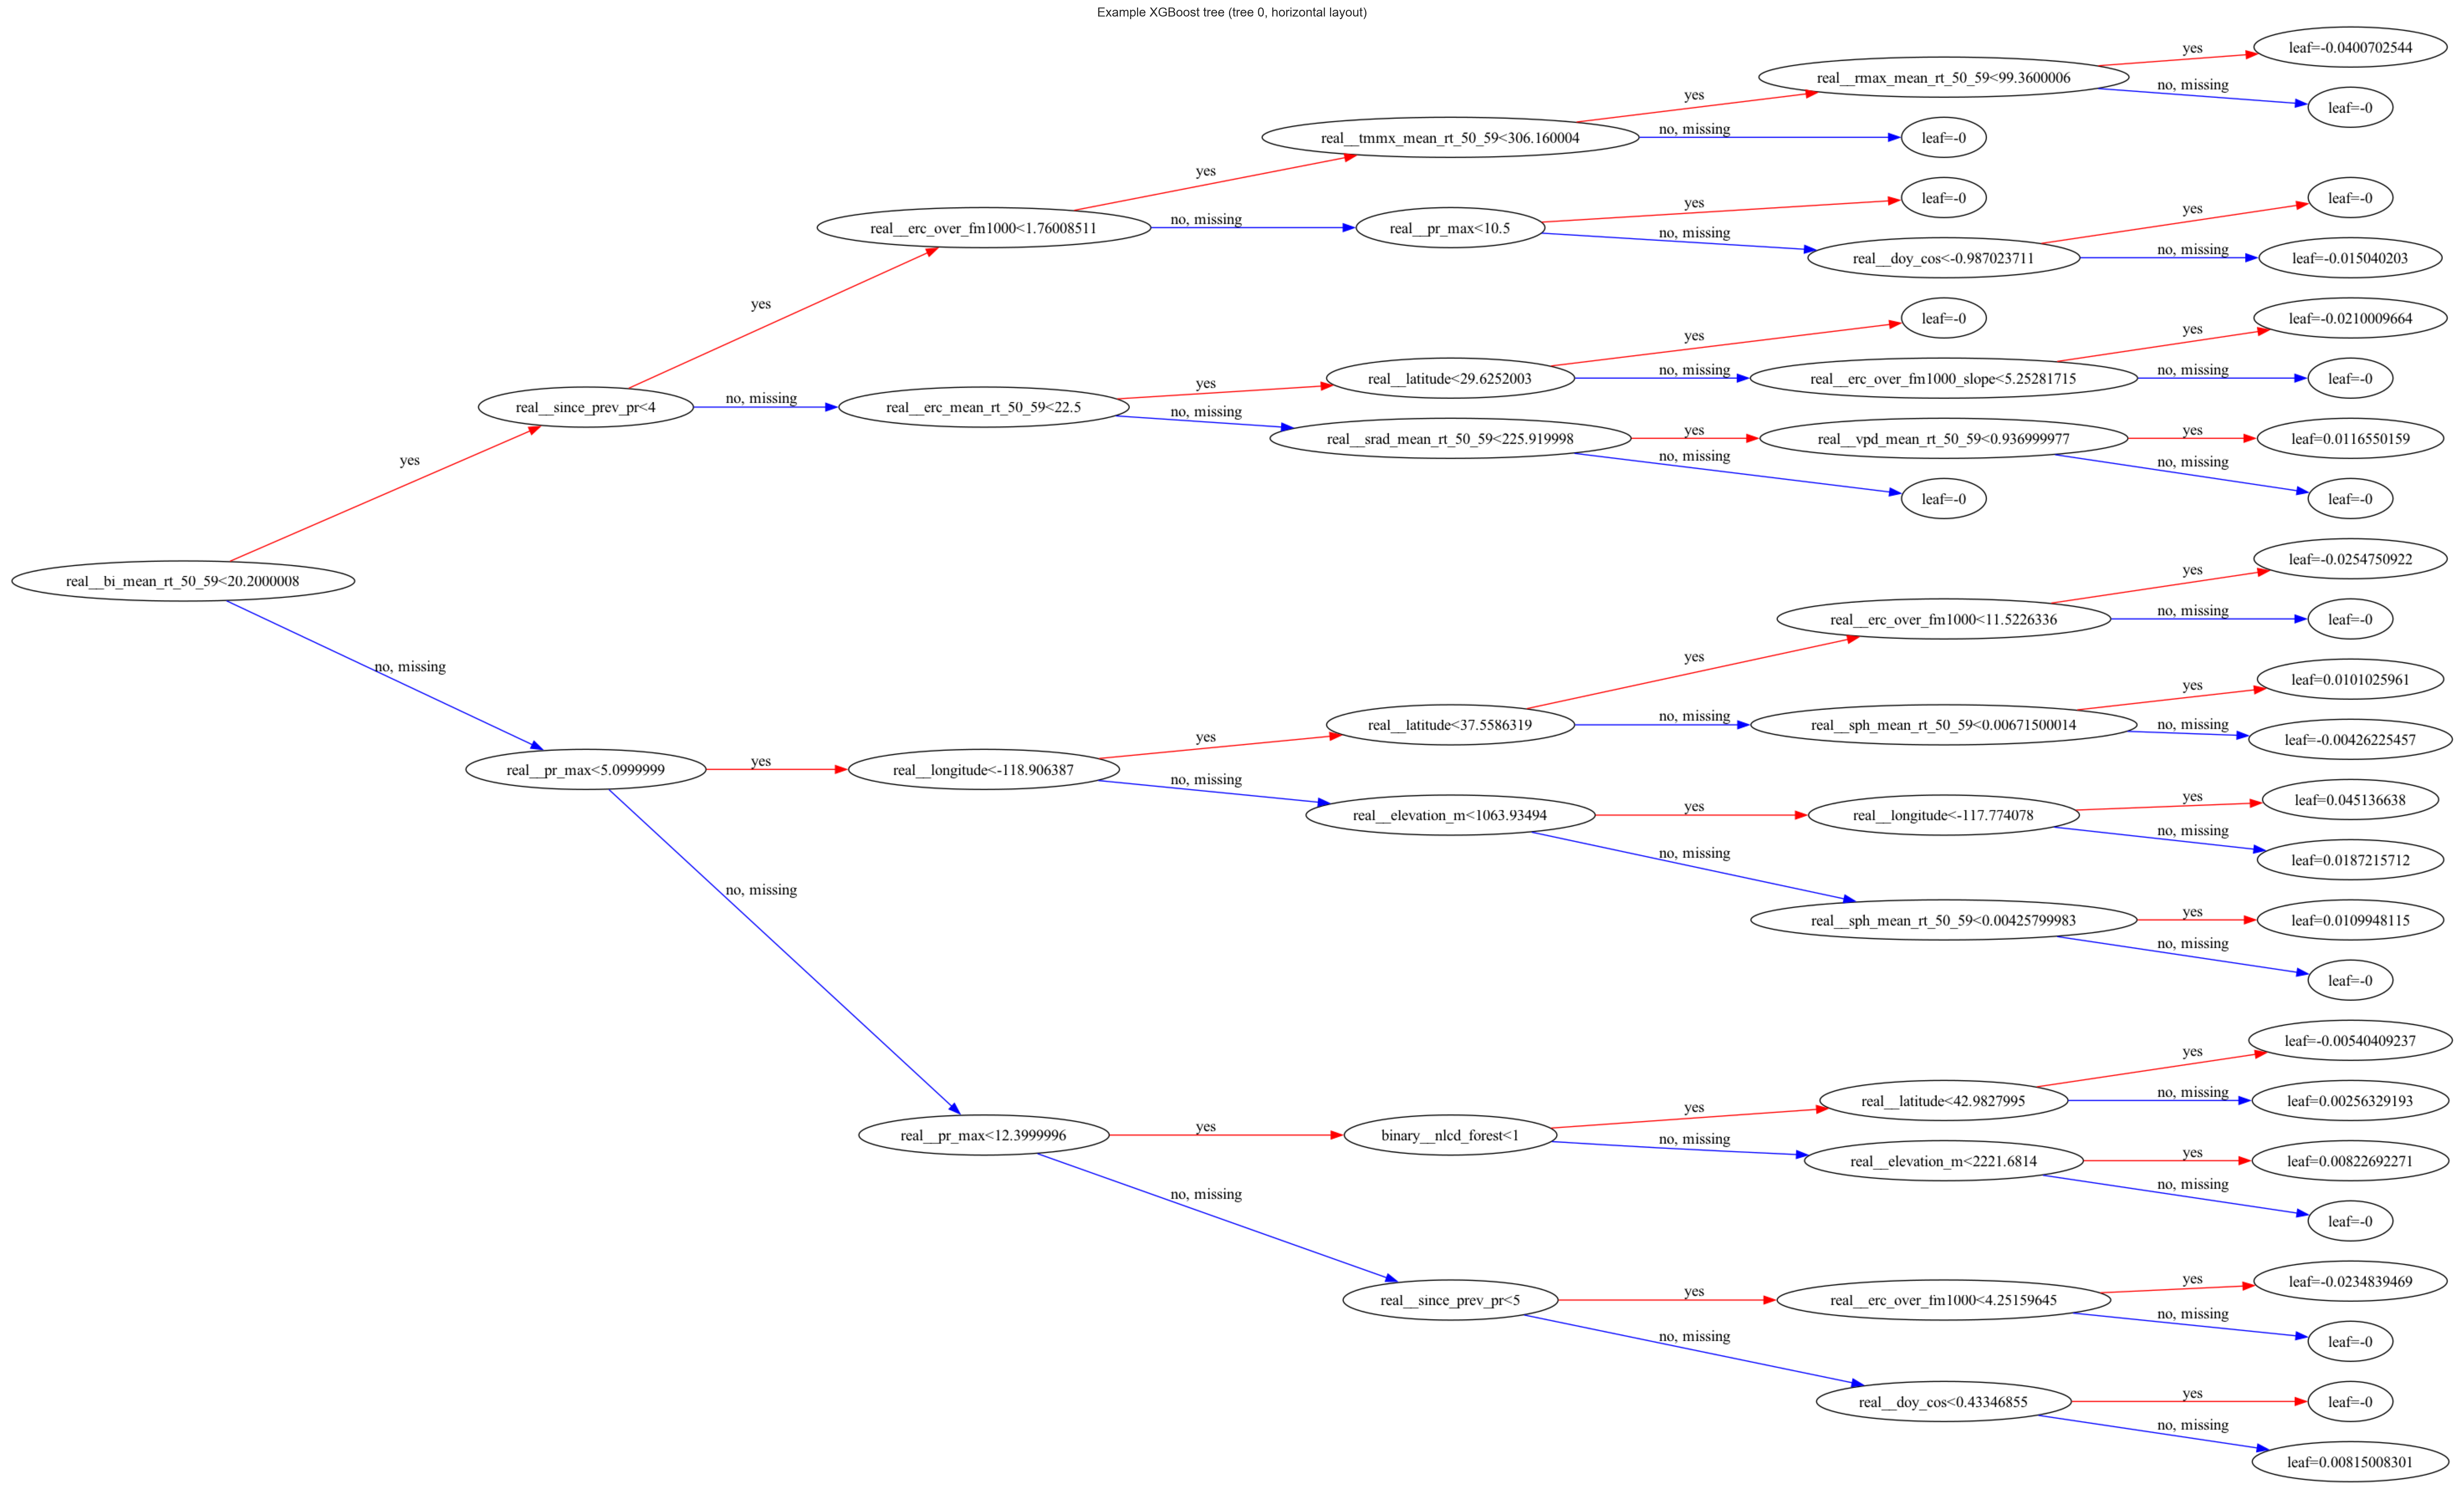

In [ ]:
from xgboost import plot_tree
import matplotlib.pyplot as plt

# Make matplotlib figures large and high-resolution
plt.rcParams["figure.figsize"] = (40, 20)   # width, height in inches
plt.rcParams["figure.dpi"] = 200            # higher DPI improves text readability

# Plot a single tree horizontally
fig, ax = plt.subplots()
plot_tree(
    booster_final,    # booster_final already has feature names attached
    num_trees=11,      # change to 1, 2, ... to inspect other trees
    rankdir="LR",     # "Left-to-Right" instead of "Up-to-Down"
    ax=ax
)
ax.set_title("Example XGBoost tree (tree 0, horizontal layout)")
plt.tight_layout()
plt.show()

100%|===================| 19427/19454 [04:06<00:00]        

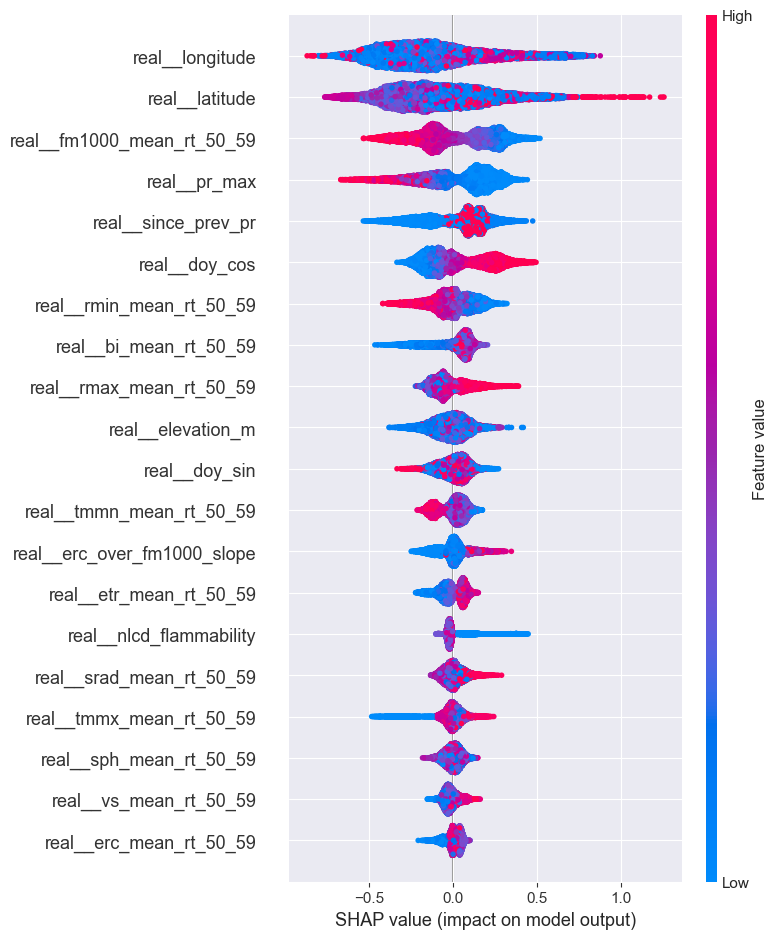

In [ ]:

shap.initjs()  # enables JS plots in notebooks

# X_trainval_proc already exists (fit on 2014–2021)
n_background = 2000  # adjust depending on memory/compute
idx_bg = np.random.choice(X_trainval_proc.shape[0], size=n_background, replace=False)
X_bg = X_trainval_proc[idx_bg]
# Option A (recommended for faithfulness): log-odds output
explainer = shap.TreeExplainer(final_model, data=X_bg)

# For newer SHAP versions, use explainer(X):
shap_values_test1 = explainer(X_test1_proc)   # returns shap.Explanation

feature_names = preprocessor_final.get_feature_names_out()
# If you got shap.Explanation:
shap.summary_plot(
    shap_values_test1.values,   # or shap_values_test2 if it is a plain ndarray
    X_test1_proc,
    feature_names=feature_names,
    show=True
)

## Error Analysis

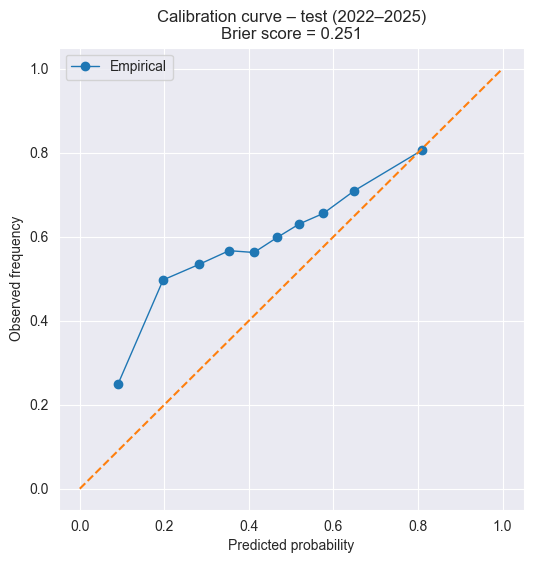

                  brier_score
test (2022–2025)     0.251428


In [ ]:
brier_scores = {}

brier_scores["test (2022–2025)"] = plot_calibration(y_test, y_test1_proba,
                                                     "test (2022–2025)")

brier_df = pd.DataFrame.from_dict(brier_scores, orient="index",
                                  columns=["brier_score"])
print(brier_df)

In [ ]:
# err_test1: 2022–2025 test split
err_test1 = build_error_df(
    X_test,
    y_test,
    y_test1_proba,
    split_name="test (2022–2025)",
    threshold=thr,
)



print("Counts by error_type – test:")
print(err_test1["error_type"].value_counts())

Counts by error_type – test:
error_type
FN    6017
TN    5912
TP    5285
FP    2240
Name: count, dtype: int64


=== Spatial errors  ===


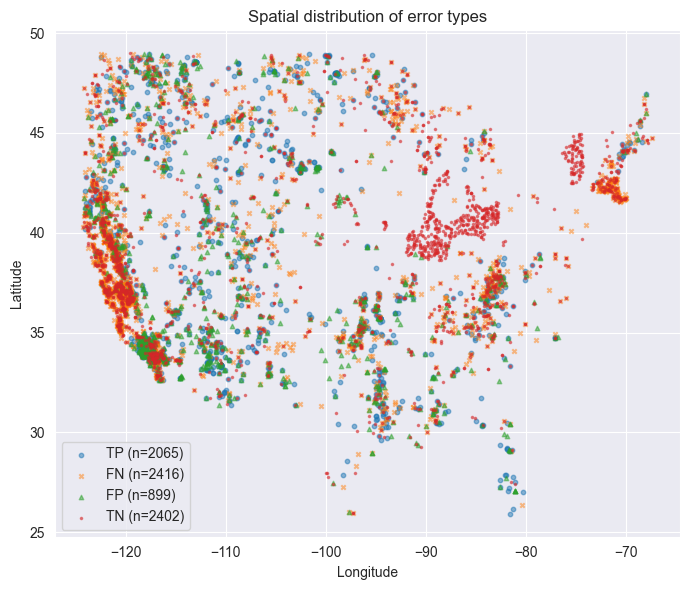

In [ ]:
print("=== Spatial errors  ===")
plot_geo_errors(err_test1, sample_frac=0.4)

In [ ]:
print("=== Extreme FNs – test (2022–2025) ===")
extreme_fn_t1 = get_extreme_errors(err_test1, error_type="FN", k=500)
display(extreme_fn_t1[[
    "y_true", "y_pred", "y_proba",
    "elevation_m", "slope_deg", "bi_mean_rt_50_59"
]])

print("=== Extreme FPs – test1 (2022–2023) ===")
extreme_fp_t1 = get_extreme_errors(err_test1, error_type="FP", k=500)
display(extreme_fp_t1[[
    "y_true", "y_pred", "y_proba",
    "elevation_m", "slope_deg", "bi_mean_rt_50_59"
]])

=== Extreme FNs – test (2022–2025) ===


y_true  y_pred   y_proba  elevation_m  slope_deg  bi_mean_rt_50_59
10323       1       0  0.037194    70.576126   2.041185              12.9
8516        1       0  0.038863   371.148834   2.000000              16.0
12738       1       0  0.041942    28.133409   1.891296              14.4
15756       1       0  0.043170    80.000000   0.000000              15.3
5385        1       0  0.044462    19.774828   1.000000              18.0
...       ...     ...       ...          ...        ...               ...
8680        1       0  0.150254    42.000004   0.000000              19.7
14260       1       0  0.150399    81.038147   0.000000              13.7
18445       1       0  0.150407    70.000000   0.000000              10.9
3764        1       0  0.150444    43.955963   0.955965               0.0
8398        1       0  0.150539     7.000000   0.000000              26.3

[500 rows x 6 columns]

=== Extreme FPs – test1 (2022–2023) ===


y_true  y_pred   y_proba  elevation_m  slope_deg  bi_mean_rt_50_59
14716       0       1  0.953021   114.000000   1.000000              53.7
4595        0       1  0.950275   731.812134   4.216202              73.0
6595        0       1  0.948648    29.046528   3.499230              33.1
18318       0       1  0.947878    48.957504   0.111721              25.2
14136       0       1  0.947264    61.000000   0.833252              38.4
...       ...     ...       ...          ...        ...               ...
2649        0       1  0.672019   324.166321   1.824643              19.3
8231        0       1  0.671990    24.960732   0.939529              19.9
1217        0       1  0.671926  1003.215820   1.588280              22.9
12625       0       1  0.671767  1358.627930   0.616399              26.0
3092        0       1  0.671450   153.148376   2.851623              23.1

[500 rows x 6 columns]

In [ ]:
## Identify error clusters for all FNs - idea: FNS are undesired for us


# select numeric features (the original 34)
feature_cols_num = numeric_cols  # from your earlier code
fn_df = err_test1[err_test1["error_type"] == "FN"].copy()

X_fn = fn_df[feature_cols_num].values
X_fn_scaled = StandardScaler().fit_transform(X_fn)

k = 7  ## Selected on Elbow (Elbow Excluded from this specific notebook)
kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init="auto")
fn_df["cluster"] = kmeans.fit_predict(X_fn_scaled)

# summarise clusters
cluster_summary = fn_df.groupby("cluster")[feature_cols_num].agg(["mean", "std", "count"])
display(cluster_summary.T)

# --- Save full tables to disk ---
# 1) Per-sample false negative table with assigned clusters
fn_df.to_csv("fn_clusters_full.csv", index=False)

# 2) Aggregated cluster summary table
cluster_summary.to_csv("fn_clusters_summary.csv")

# Still display the summary in the notebook

/Users/anatolelobenko/PyCharmMiscProject/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/anatolelobenko/PyCharmMiscProject/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/anatolelobenko/PyCharmMiscProject/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/anatolelobenko/PyCharmMiscProject/.venv/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/anatolelobenko/PyCharmMiscProject/.venv/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/anatolelobenko/PyCharmMiscProject/.venv/lib/python3.13/site-packages/

cluster                               0           1            2           3  \
latitude              mean    36.633504   39.547805    37.637920   39.839087   
                      std      2.398972    5.183576     3.890473    4.943928   
                      count  911.000000  437.000000  1523.000000  739.000000   
longitude             mean  -118.837437 -104.640493  -115.953660 -100.242961   
                      std      3.660084   14.226993    10.934860   18.413348   
...                                 ...         ...          ...         ...   
erc_over_fm1000       std      3.969227    2.114579     1.805254    1.009287   
                      count  911.000000  437.000000  1523.000000  739.000000   
erc_over_fm1000_slope mean    14.228717   11.746359     9.503368   15.161728   
                      std     26.264821   18.346956    16.145660   17.540784   
                      count  911.000000  437.000000  1523.000000  739.000000   

cluster                               4           5            6  
latitude              mean    38.481181   40.900672    38.189001  
                      std      4.499754    6.031075     3.483472  
                      count  506.000000  122.000000  1779.000000  
longitude             mean  -114.470054  -93.188815  -111.288741  
                      std      6.025186   17.064239    16.654558  
...                                 ...         ...          ...  
erc_over_fm1000       std      5.034360    1.843181     0.958482  
                      count  506.000000  122.000000  1779.000000  
erc_over_fm1000_slope mean    65.295429    3.360550     3.889299  
                      std     77.210153    7.095160     6.539748  
                      count  506.000000  122.000000  1779.000000  

[102 rows x 7 columns]

In [ ]:
#Error over years in test
err_test_with_year = err_test1.copy()
err_test_with_year["year"] = test_df["year"].values  # assuming same order

error_rate_by_year = (
    err_test_with_year
    .assign(is_error=lambda d: d["error_type"].isin(["FP", "FN"]).astype(int))
    .groupby("year")["is_error"]
    .mean()
)
print(error_rate_by_year)

year
2022    0.389214
2023    0.448212
2024    0.472061
2025    0.269147
Name: is_error, dtype: float64


## Calibration

In [ ]:
# Example: target recall of 0.90 on fires in VALIDATION!
thr_high_recall, stats_high_recall = choose_threshold_for_high_recall(
    y_val,
    y_val_proba_s2,
    recall_target=0.90,
)

print(f"High-recall threshold: {thr_high_recall:.3f}")
print("Validation metrics at that threshold:", stats_high_recall)

High-recall threshold: 0.310
Validation metrics at that threshold: {'precision': 0.25960899055725495, 'recall': 0.9055903502667595, 'counts': {'fp': 11134, 'fn': 407}}



=== test (2022–2025) @ thr=0.310 ===
precision : 0.6450
recall    : 0.7938
f1        : 0.7118
accuracy  : 0.6265
roc_auc   : 0.6539
pr_auc    : 0.7127
Confusion matrix:
 [[3215 4937]
 [2330 8972]]


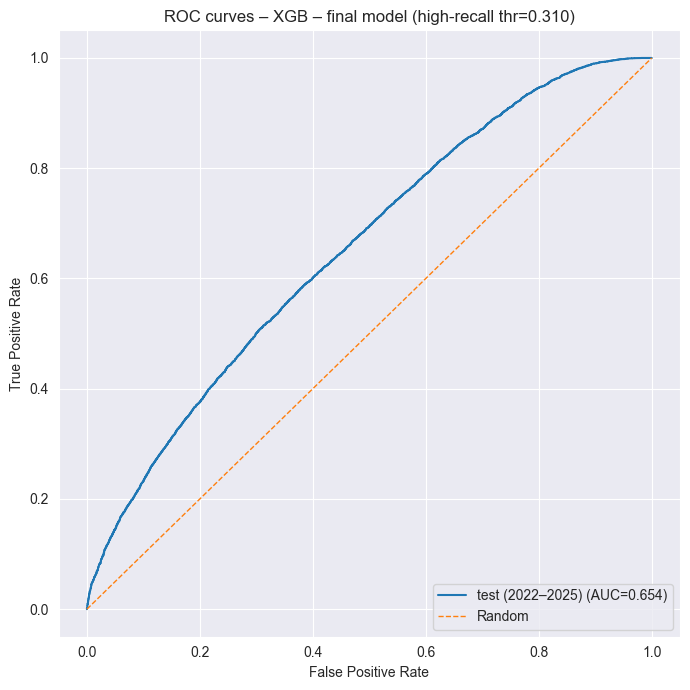

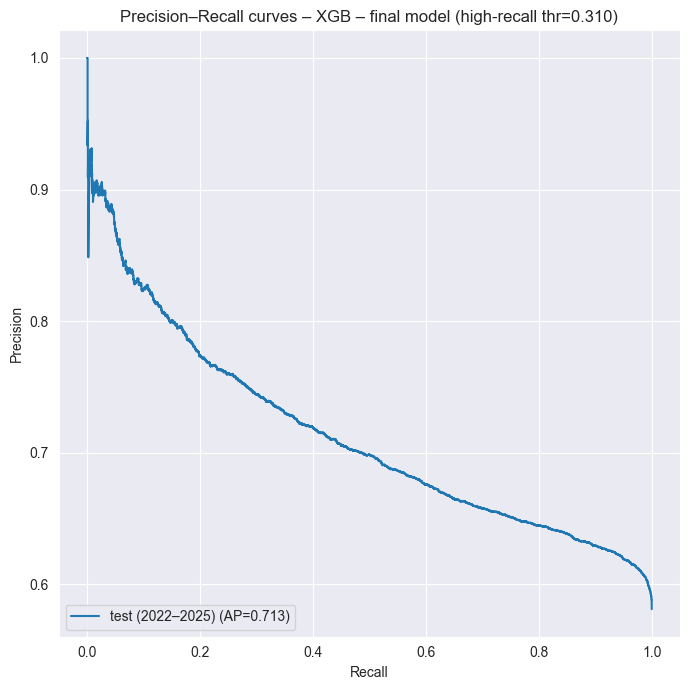

In [ ]:
results_high_recall = eval_multiple_splits(
    splits,
    threshold=thr_high_recall,
    title_prefix=f"XGB – final model (high-recall thr={thr_high_recall:.3f})",
)

Confusion matrix – test (2022–2025) @ high-recall thr=0.310 @ thr=0.310
Confusion matrix (rows = true, cols = predicted):
[[3215 4937]
 [2330 8972]]

TN=3215, FP=4937, FN=2330, TP=8972

Row-normalised confusion matrix:
[[0.39438175 0.60561825]
 [0.2061582  0.7938418 ]]


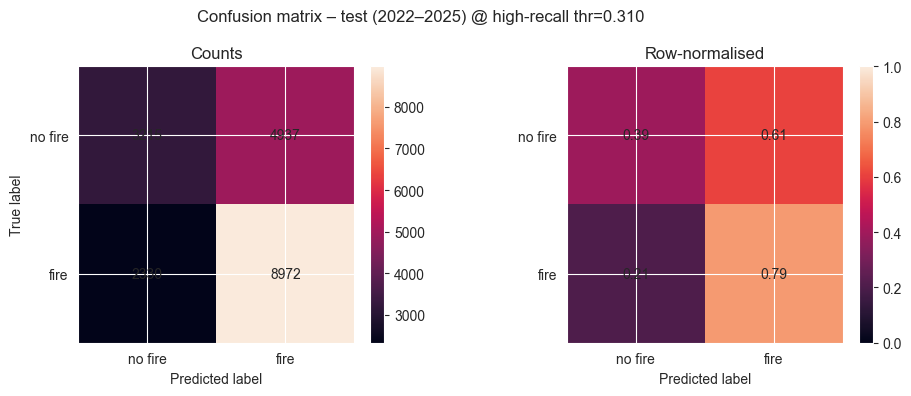

In [ ]:
cm_t1_hr, cm_t1_norm_hr = plot_confusion_matrix_from_proba(
    y_test,
    y_test1_proba,
    threshold=thr_high_recall,
    title=f"Confusion matrix – test (2022–2025) @ high-recall thr={thr_high_recall:.3f}",
)


Now a bit more tricky, we want to address the classes indentified in error analysis: urban and shrub/forest wrt. to elevation & "erc_over_fm1000" & "erc_over_fm1000_slope"

In [ ]:
def predict_with_regime_thresholds(y_proba, regimes,
                                   thr_base,
                                   thr_urban_delta=0.0,
                                   thr_high_elev_delta=0.0):
    """
    Apply regime-conditional thresholds.

    Parameters
    ----------
    y_proba : array-like
        Predicted probabilities for fire (class 1).
    regimes : dict
        {"urban": mask_urban, "high_elev_fuel": mask_high_elev, "base": mask_base}
        All masks must be boolean arrays of same length, disjoint, and cover all samples.
    thr_base : float
        Base decision threshold (e.g. global high-recall threshold).
    thr_urban_delta : float
        Delta applied in the urban regime (negative = lower threshold).
    thr_high_elev_delta : float
        Delta applied in the high-elevation shrub/forest regime.

    Returns
    -------
    y_pred : ndarray of shape (n_samples,)
        Hard predictions after applying regime-conditional thresholds.
    thr_used : ndarray of shape (n_samples,)
        The threshold actually used per sample (for diagnostics).
    """
    y_proba = np.asarray(y_proba)
    n = y_proba.shape[0]
    thr_used = np.full(n, thr_base, dtype=float)

    urban_mask = regimes["urban"]
    high_elev_mask = regimes["high_elev_fuel"]
    base_mask = regimes["base"]

    thr_used[urban_mask] = thr_base + thr_urban_delta
    thr_used[high_elev_mask] = thr_base + thr_high_elev_delta
    # base_mask already set to thr_base

    y_pred = (y_proba >= thr_used).astype(int)
    return y_pred, thr_used

In [ ]:
HUMAN_PRESENCE_GRID = [2, 3, 4, 5]
ELEVATION_GRID      = [1000.0, 1500.0, 2000.0]
ERC_GRID            = [0.5, 1.0, 1.5]
ERC_SLOPE_GRID      = [-0.1, 0.0, 0.1]

thr_base = thr_high_recall  # use your calibrated base threshold

grid_results = []
for hp_thr in HUMAN_PRESENCE_GRID:
    for elev_thr in ELEVATION_GRID:
        for erc_thr in ERC_GRID:
            for slope_thr in ERC_SLOPE_GRID:
                metrics = eval_regime_thresholds(
                    human_presence_thr=hp_thr,
                    elevation_thr=elev_thr,
                    erc_thr=erc_thr,
                    erc_slope_thr=slope_thr,
                    thr_base=thr_base,
                    thr_urban_delta=0.0,
                    thr_high_elev_delta=0.0,
                )
                grid_results.append({
                    "human_presence_thr": hp_thr,
                    "elevation_thr": elev_thr,
                    "erc_thr": erc_thr,
                    "erc_slope_thr": slope_thr,
                    **metrics,
                })

results_regime_grid = pd.DataFrame(grid_results)

In [ ]:
results_regime_grid["score"] = (
    1.0 * results_regime_grid["f1"]
    - 0.5 * results_regime_grid["urban_fn_rate"]
    - 0.5 * results_regime_grid["high_fn_rate"]
)
best_combo = results_regime_grid.sort_values("score", ascending=False).head(1)
print(best_combo)

    human_presence_thr  elevation_thr  erc_thr  erc_slope_thr  precision  \
60                   4         1000.0      1.5           -0.1   0.259609   

     recall        f1  urban_fn_rate  high_fn_rate     score  
60  0.90559  0.403535       0.083077      0.057232  0.333381  


In [ ]:
# After you compute best_combo
best_idx = results_regime_grid["score"].idxmax()
best = results_regime_grid.loc[best_idx]

BEST_HUMAN_PRESENCE_THR = float(best["human_presence_thr"])
BEST_ELEVATION_THR      = float(best["elevation_thr"])
BEST_ERC_THR            = float(best["erc_thr"])
BEST_ERC_SLOPE_THR      = float(best["erc_slope_thr"])

# Regimes on validation
regimes_val = make_regime_masks(
    val_df,
    human_presence_thr=BEST_HUMAN_PRESENCE_THR,
    elevation_thr=BEST_ELEVATION_THR,
    erc_thr=BEST_ERC_THR,
    erc_slope_thr=BEST_ERC_SLOPE_THR,
)

# Regimes on test
regimes_test = make_regime_masks(
    test_df,
    human_presence_thr=BEST_HUMAN_PRESENCE_THR,
    elevation_thr=BEST_ELEVATION_THR,
    erc_thr=BEST_ERC_THR,
    erc_slope_thr=BEST_ERC_SLOPE_THR,
)

In [ ]:
thr_base = thr_high_recall
#thr_base = 0.5
search_results = []
for d_urban in [0.0, -0.02, -0.04, -0.06]:
    for d_high in [0.0, -0.02, -0.04]:
        y_pred_val, thr_used = predict_with_regime_thresholds(
            y_proba=y_val_proba_s2,
            regimes=regimes_val,
            thr_base=thr_base,
            thr_urban_delta=d_urban,
            thr_high_elev_delta=d_high,
        )
        # global metrics
        from sklearn.metrics import precision_score, recall_score, f1_score
        prec = precision_score(y_val, y_pred_val, zero_division=0)
        rec  = recall_score(y_val, y_pred_val)
        f1   = f1_score(y_val, y_pred_val)

        # FN rate in urban regime
        urban_mask = regimes_val["urban"]
        y_true_u = y_val.values[urban_mask]
        y_pred_u = y_pred_val[urban_mask]
        fn_u = ((y_true_u == 1) & (y_pred_u == 0)).sum()
        tp_u = ((y_true_u == 1) & (y_pred_u == 1)).sum()
        fn_rate_u = fn_u / (fn_u + tp_u + 1e-9)

        search_results.append({
            "d_urban": d_urban,
            "d_high": d_high,
            "precision": prec,
            "recall": rec,
            "f1": f1,
            "urban_fn_rate": fn_rate_u,
        })

results_regime = pd.DataFrame(search_results)
display(results_regime.sort_values("urban_fn_rate").head(10))

d_urban  d_high  precision    recall        f1  urban_fn_rate
9     -0.06    0.00   0.253001  0.919044  0.396775       0.047385
10    -0.06   -0.02   0.252331  0.922756  0.396294       0.047385
11    -0.06   -0.04   0.251575  0.926235  0.395680       0.047385
6     -0.04    0.00   0.255303  0.915797  0.399292       0.056000
7     -0.04   -0.02   0.254609  0.919508  0.398793       0.056000
8     -0.04   -0.04   0.253828  0.922988  0.398159       0.056000
3     -0.02    0.00   0.258024  0.911853  0.402231       0.066462
4     -0.02   -0.02   0.257301  0.915565  0.401710       0.066462
5     -0.02   -0.04   0.256490  0.919044  0.401053       0.066462
0      0.00    0.00   0.259609  0.905590  0.403535       0.083077

In [ ]:
best_d_urban = -0.06
best_d_high = -0.04

In [ ]:
# Final validation predictions with regime thresholds
y_val_pred_regime, thr_val_used = predict_with_regime_thresholds(
    y_proba=y_val_proba_s2,
    regimes=regimes_val,
    thr_base=thr_base,
    thr_urban_delta=best_d_urban,
    thr_high_elev_delta=best_d_high,
)
from sklearn.metrics import confusion_matrix

def metrics_by_regime(y_true, y_pred, regimes, regime_name):
    mask = regimes[regime_name]
    cm = confusion_matrix(y_true[mask], y_pred[mask])
    tn, fp, fn, tp = cm.ravel()
    print(f"\n=== {regime_name} regime ===")
    print("n =", mask.sum())
    print("Confusion matrix:\n", cm)
    print("FN rate =", fn / (fn + tp + 1e-9))
    print("FP rate =", fp / (fp + tn + 1e-9))

for reg in ["urban", "high_elev_fuel", "base"]:
    metrics_by_regime(y_val.values, y_val_pred_regime, regimes_val, reg)



=== urban regime ===
n = 7613
Confusion matrix:
 [[1649 4339]
 [  77 1548]]
FN rate = 0.04738461538458622
FP rate = 0.7246158984634727

=== high_elev_fuel regime ===
n = 4342
Confusion matrix:
 [[ 165 3216]
 [  24  937]]
FN rate = 0.024973985431815844
FP rate = 0.9511978704522475

=== base regime ===
n = 9326
Confusion matrix:
 [[3277 4324]
 [ 217 1508]]
FN rate = 0.12579710144920245
FP rate = 0.5688725167740338


In [ ]:
y_test_pred_regime, thr_test_used = predict_with_regime_thresholds(
    y_proba=y_test1_proba,
    regimes=regimes_test,
    thr_base=thr_base,
    thr_urban_delta=best_d_urban,
    thr_high_elev_delta=best_d_high,
)

evaluate_classifier(y_test, y_test_pred_regime, y_test1_proba, dataset_name="test (regime thresholds)")


=== Evaluation on test (regime thresholds) ===
              precision    recall  f1-score   support

           0     0.6160    0.3473    0.4441      8152
           1     0.6419    0.8438    0.7291     11302

    accuracy                         0.6358     19454
   macro avg     0.6289    0.5956    0.5866     19454
weighted avg     0.6310    0.6358    0.6097     19454

ROC-AUC: 0.6539


In [ ]:

def compare_to_temp_baseline_with_preds(
    y_true,
    y_pred_model,
    temp_values,
    temp_threshold: float = 300.0,
    dataset_name: str = "dataset",
):
    """
    Version of the comparison function for arbitrary decision rules,
    including regime-conditional thresholds, where y_pred_model is
    already computed.
    """
    y_true = np.asarray(y_true)
    y_pred_model = np.asarray(y_pred_model)
    temp_values = np.asarray(temp_values)

    # Temperature baseline
    y_pred_temp = (temp_values > temp_threshold).astype(int)

    # Random 50/50 baseline
    rng = np.random.default_rng(RANDOM_STATE)
    y_pred_5050 = rng.integers(0, 2, size=y_true.shape[0])

    def _metric_dict(y_true_local, y_pred_local):
        return {
            "f1": f1_score(y_true_local, y_pred_local),
            "precision": precision_score(y_true_local, y_pred_local, zero_division=0),
            "recall": recall_score(y_true_local, y_pred_local),
            "accuracy": accuracy_score(y_true_local, y_pred_local),
        }

    metrics_model = _metric_dict(y_true, y_pred_model)
    metrics_temp  = _metric_dict(y_true, y_pred_temp)
    metrics_5050  = _metric_dict(y_true, y_pred_5050)

    df_cmp = pd.DataFrame(
        {
            "model": metrics_model,
            "temp_baseline": metrics_temp,
            "random_50_50": metrics_5050,
        }
    )

    print(f"\n=== Model vs naive, temperature, and random 50/50 baseline on {dataset_name} ===")
    display(df_cmp)

Confusion matrix – test (2022–2025) regime thresholds
Confusion matrix (rows = true, cols = predicted):
[[2831 5321]
 [1765 9537]]

TN=2831, FP=5321, FN=1765, TP=9537

Row-normalised confusion matrix:
[[0.34727674 0.65272326]
 [0.15616705 0.84383295]]


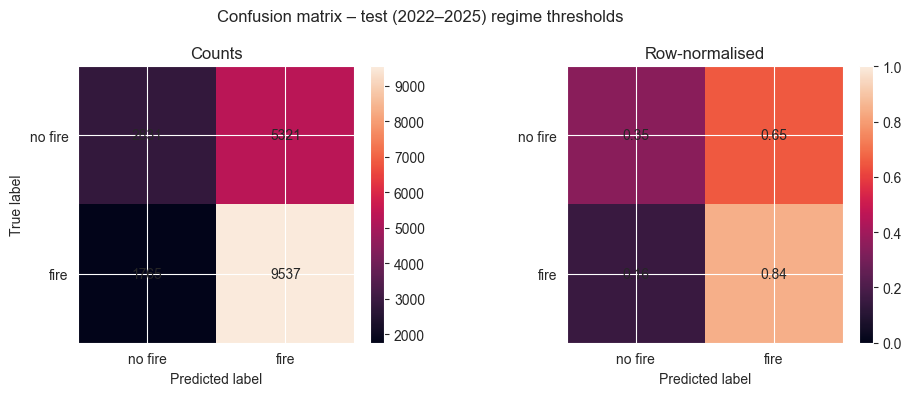

In [ ]:
cm_reg, cm_reg_norm = plot_confusion_matrix_from_preds(
    y_test,
    y_test_pred_regime,
    title="Confusion matrix – test (2022–2025) regime thresholds",
)

In [ ]:
# y_test_pred_regime already computed via predict_with_regime_thresholds(...)
compare_to_temp_baseline_with_preds(
    y_true=y_test,
    y_pred_model=y_test_pred_regime,
    temp_values=X_test["tmmx_mean_rt_50_59"],
    temp_threshold=300.0,
    dataset_name="test (2022–2025, regime thresholds)",
)


=== Model vs naive, temperature, and random 50/50 baseline on test (2022–2025, regime thresholds) ===


model  temp_baseline  random_50_50
f1         0.729128       0.426074      0.530050
precision  0.641876       0.616209      0.576615
recall     0.843833       0.325606      0.490444
accuracy   0.635756       0.490388      0.494757

Fun part, tryig to make a "cost" function for better decision tresholds

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

def compute_simple_cost(
    y_true,
    y_pred,
    fn_cost: float = 10.0,
    fp_cost_avg: float = 1.8465,
    label: str = "model",
):
    """
    Compute a simple total cost for a given decision rule, based on:
      - cost(FN) = fn_cost
      - cost(FP) = fp_cost_avg

    Parameters
    ----------
    y_true : array-like
        True binary labels.
    y_pred : array-like
        Hard predictions (0/1) for the same samples.
    fn_cost : float, default=10.0
        Cost assigned to missing a fire (false negative).
    fp_cost_avg : float, default=1.8465
        Average cost of investigating a false alarm (false positive).
    label : str, default="model"
        Name of the model / threshold configuration (for printing).

    Returns
    -------
    dict with keys:
        - 'label'
        - 'fn'
        - 'fp'
        - 'cost_fn'
        - 'cost_fp'
        - 'total_cost'
    """
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)

    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    cost_fn = fn_cost * fn
    cost_fp = fp_cost_avg * fp
    total_cost = cost_fn + cost_fp

    print(f"\n=== Cost summary: {label} ===")
    print(f"FN = {fn}, FP = {fp}")
    print(f"Cost(FN) = {fn_cost:.2f} -> {cost_fn:.2f}")
    print(f"Cost(FP) = {fp_cost_avg:.4f} (avg) -> {cost_fp:.2f}")
    print(f"Total cost = {total_cost:.2f}")

    return {
        "label": label,
        "fn": int(fn),
        "fp": int(fp),
        "cost_fn": float(cost_fn),
        "cost_fp": float(cost_fp),
        "total_cost": float(total_cost),
    }

In [ ]:
# 1) Global threshold 0.5
cost_050 = compute_simple_cost(
    y_true=y_test,
    y_pred=y_test1_pred,
    label="thr=0.500",
)

# 2) High-recall global threshold (thr_high_recall = 0.310)
y_test_pred_hr = (y_test1_proba >= thr_high_recall).astype(int)
cost_hr = compute_simple_cost(
    y_true=y_test,
    y_pred=y_test_pred_hr,
    label=f"high-recall thr={thr_high_recall:.3f}",
)

# 3) Regime thresholds (already computed: y_test_pred_regime)
cost_regime = compute_simple_cost(
    y_true=y_test,
    y_pred=y_test_pred_regime,
    label="regime thresholds",
)


=== Cost summary: thr=0.500 ===
FN = 6017, FP = 2240
Cost(FN) = 10.00 -> 60170.00
Cost(FP) = 1.8465 (avg) -> 4136.16
Total cost = 64306.16

=== Cost summary: high-recall thr=0.310 ===
FN = 2330, FP = 4937
Cost(FN) = 10.00 -> 23300.00
Cost(FP) = 1.8465 (avg) -> 9116.17
Total cost = 32416.17

=== Cost summary: regime thresholds ===
FN = 1765, FP = 5321
Cost(FN) = 10.00 -> 17650.00
Cost(FP) = 1.8465 (avg) -> 9825.23
Total cost = 27475.23


In [ ]:
def evaluate_cost_scenarios(
    y_true,
    predictions: dict,
    fn_costs=(5.0, 10.0, 20.0),
    fp_costs=(0.5, 1.0, 1.8465, 3.0),
):
    """
    Evaluate several (FN_cost, FP_cost) scenarios for multiple decision rules.

    Parameters
    ----------
    y_true : array-like
        True labels on the test set.
    predictions : dict
        Mapping {model_label: y_pred}, e.g.
        {
          "thr=0.500": y_test1_pred,
          "high-recall": y_test_pred_hr,
          "regime": y_test_pred_regime,
        }
    fn_costs : iterable of float
        Candidate costs for missing a fire (FN). Must be > 0.
    fp_costs : iterable of float
        Candidate average costs for a false alarm (FP). Must be > 0.
        We will only evaluate combinations where fn_cost > fp_cost.

    Returns
    -------
    pd.DataFrame
        One row per (model, fn_cost, fp_cost) with total_cost, FN, FP, etc.
    """
    rows = []

    for model_label, y_pred in predictions.items():
        for fn_c in fn_costs:
            for fp_c in fp_costs:
                # enforce "missing a fire is more expensive than FP"
                if fn_c <= fp_c:
                    continue

                res = compute_simple_cost(
                    y_true=y_true,
                    y_pred=y_pred,
                    fn_cost=fn_c,
                    fp_cost_avg=fp_c,
                    label=f"{model_label} (fn={fn_c}, fp={fp_c})",
                )

                rows.append({
                    "model": model_label,
                    "fn_cost": fn_c,
                    "fp_cost": fp_c,
                    "fn": res["fn"],
                    "fp": res["fp"],
                    "cost_fn": res["cost_fn"],
                    "cost_fp": res["cost_fp"],
                    "total_cost": res["total_cost"],
                })

    df = pd.DataFrame(rows)
    return df

In [ ]:
predictions_test = {
    "thr=0.500": y_test1_pred,
    f"high-recall thr={thr_high_recall:.3f}": y_test_pred_hr,
    "regime thresholds": y_test_pred_regime,
}

cost_grid = evaluate_cost_scenarios(
    y_true=y_test,
    predictions=predictions_test,
    fn_costs=(5.0, 10.0, 20.0),
    fp_costs=(0.5, 1.0, 1.8465, 3.0),
)

display(cost_grid.sort_values("total_cost").head(40))


=== Cost summary: thr=0.500 (fn=5.0, fp=0.5) ===
FN = 6017, FP = 2240
Cost(FN) = 5.00 -> 30085.00
Cost(FP) = 0.5000 (avg) -> 1120.00
Total cost = 31205.00

=== Cost summary: thr=0.500 (fn=5.0, fp=1.0) ===
FN = 6017, FP = 2240
Cost(FN) = 5.00 -> 30085.00
Cost(FP) = 1.0000 (avg) -> 2240.00
Total cost = 32325.00

=== Cost summary: thr=0.500 (fn=5.0, fp=1.8465) ===
FN = 6017, FP = 2240
Cost(FN) = 5.00 -> 30085.00
Cost(FP) = 1.8465 (avg) -> 4136.16
Total cost = 34221.16

=== Cost summary: thr=0.500 (fn=5.0, fp=3.0) ===
FN = 6017, FP = 2240
Cost(FN) = 5.00 -> 30085.00
Cost(FP) = 3.0000 (avg) -> 6720.00
Total cost = 36805.00

=== Cost summary: thr=0.500 (fn=10.0, fp=0.5) ===
FN = 6017, FP = 2240
Cost(FN) = 10.00 -> 60170.00
Cost(FP) = 0.5000 (avg) -> 1120.00
Total cost = 61290.00

=== Cost summary: thr=0.500 (fn=10.0, fp=1.0) ===
FN = 6017, FP = 2240
Cost(FN) = 10.00 -> 60170.00
Cost(FP) = 1.0000 (avg) -> 2240.00
Total cost = 62410.00

=== Cost summary: thr=0.500 (fn=10.0, fp=1.8465) ===
FN 

model  fn_cost  fp_cost    fn    fp   cost_fn     cost_fp  \
24      regime thresholds      5.0   0.5000  1765  5321    8825.0   2660.5000   
12  high-recall thr=0.310      5.0   0.5000  2330  4937   11650.0   2468.5000   
25      regime thresholds      5.0   1.0000  1765  5321    8825.0   5321.0000   
13  high-recall thr=0.310      5.0   1.0000  2330  4937   11650.0   4937.0000   
26      regime thresholds      5.0   1.8465  1765  5321    8825.0   9825.2265   
28      regime thresholds     10.0   0.5000  1765  5321   17650.0   2660.5000   
14  high-recall thr=0.310      5.0   1.8465  2330  4937   11650.0   9116.1705   
29      regime thresholds     10.0   1.0000  1765  5321   17650.0   5321.0000   
27      regime thresholds      5.0   3.0000  1765  5321    8825.0  15963.0000   
16  high-recall thr=0.310     10.0   0.5000  2330  4937   23300.0   2468.5000   
15  high-recall thr=0.310      5.0   3.0000  2330  4937   11650.0  14811.0000   
30      regime thresholds     10.0   1.8465  1765  5321   17650.0   9825.2265   
17  high-recall thr=0.310     10.0   1.0000  2330  4937   23300.0   4937.0000   
0               thr=0.500      5.0   0.5000  6017  2240   30085.0   1120.0000   
1               thr=0.500      5.0   1.0000  6017  2240   30085.0   2240.0000   
18  high-recall thr=0.310     10.0   1.8465  2330  4937   23300.0   9116.1705   
31      regime thresholds     10.0   3.0000  1765  5321   17650.0  15963.0000   
2               thr=0.500      5.0   1.8465  6017  2240   30085.0   4136.1600   
3               thr=0.500      5.0   3.0000  6017  2240   30085.0   6720.0000   
32      regime thresholds     20.0   0.5000  1765  5321   35300.0   2660.5000   
19  high-recall thr=0.310     10.0   3.0000  2330  4937   23300.0  14811.0000   
33      regime thresholds     20.0   1.0000  1765  5321   35300.0   5321.0000   
34      regime thresholds     20.0   1.8465  1765  5321   35300.0   9825.2265   
20  high-recall thr=0.310     20.0   0.5000  2330  4937   46600.0   2468.5000   
35      regime thresholds     20.0   3.0000  1765  5321   35300.0  15963.0000   
21  high-recall thr=0.310     20.0   1.0000  2330  4937   46600.0   4937.0000   
22  high-recall thr=0.310     20.0   1.8465  2330  4937   46600.0   9116.1705   
4               thr=0.500     10.0   0.5000  6017  2240   60170.0   1120.0000   
23  high-recall thr=0.310     20.0   3.0000  2330  4937   46600.0  14811.0000   
5               thr=0.500     10.0   1.0000  6017  2240   60170.0   2240.0000   
6               thr=0.500     10.0   1.8465  6017  2240   60170.0   4136.1600   
7               thr=0.500     10.0   3.0000  6017  2240   60170.0   6720.0000   
8               thr=0.500     20.0   0.5000  6017  2240  120340.0   1120.0000   
9               thr=0.500     20.0   1.0000  6017  2240  120340.0   2240.0000   
10              thr=0.500     20.0   1.8465  6017  2240  120340.0   4136.1600   
11              thr=0.500     20.0   3.0000  6017  2240  120340.0   6720.0000   

     total_cost  
24   11485.5000  
12   14118.5000  
25   14146.0000  
13   16587.0000  
26   18650.2265  
28   20310.5000  
14   20766.1705  
29   22971.0000  
27   24788.0000  
16   25768.5000  
15   26461.0000  
30   27475.2265  
17   28237.0000  
0    31205.0000  
1    32325.0000  
18   32416.1705  
31   33613.0000  
2    34221.1600  
3    36805.0000  
32   37960.5000  
19   38111.0000  
33   40621.0000  
34   45125.2265  
20   49068.5000  
35   51263.0000  
21   51537.0000  
22   55716.1705  
4    61290.0000  
23   61411.0000  
5    62410.0000  
6    64306.1600  
7    66890.0000  
8   121460.0000  
9   122580.0000  
10  124476.1600  
11  127060.0000